# Fully-saturated TWFE

In [2]:
import re
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df['log_pop'] = np.log(df['populations'])

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{k \notin C}\sum_{l \in L} \delta_{lk} \mathbf{1}[G_k=k]\mathbf{1}[t-k=l] + \epsilon_{it}
$$

## ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


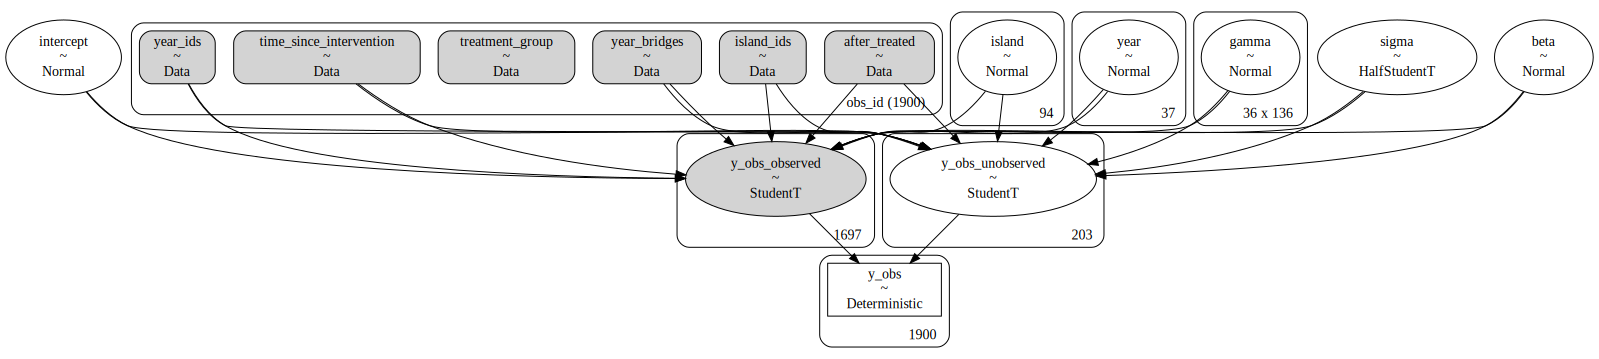

In [15]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_year_ids = pd.factorize(df['years'])
df['year_bridges_opened'], unique_year_bridges_opened = pd.factorize(df['year_bridges_opened'])
unique_time_since_intervention = len(df['time_since_intervention'].unique())
unique_year_bridges_opened = len(df['year_bridges_opened'].unique())

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as fully_saturated:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['years'], dims='obs_id')
    after_treated = pm.Data('after_treated', df['after_treated'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'], dims='obs_id')
    year_bridges = pm.Data('year_bridges', df['year_bridges_opened'], dims='obs_id')

    # priors
    # random effects
    island = pm.Normal('island', mu=0, sigma=1, shape=len(unique_island_ids))
    year = pm.Normal('year', mu=0, sigma=1, shape=len(unique_year_ids))
    gamma = pm.Normal('gamma', mu=0, sigma=1, shape=(unique_year_bridges_opened, unique_time_since_intervention))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + (beta + gamma[year_bridges, time_since_intervention]) * after_treated + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(fully_saturated)

In [16]:
with fully_saturated:
    trace_fully_saturated = pm.sample(
        draws=1000,
        tune=500,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )
    pm.compute_log_likelihood(trace_fully_saturated)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [34]:
az.summary(trace_fully_saturated, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.358,0.193,4.979,5.703,0.023,0.016,74.0,229.0,1.01
beta,0.372,0.067,0.245,0.500,0.008,0.006,69.0,215.0,1.01
sigma,0.110,0.003,0.104,0.117,0.000,0.000,859.0,1206.0,1.00


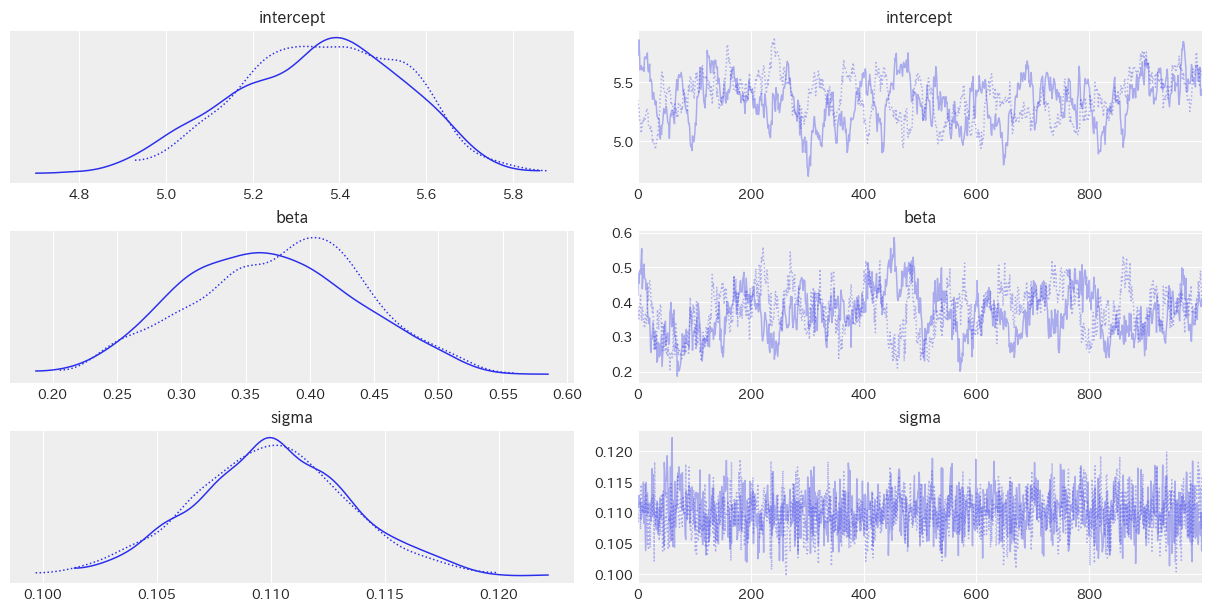

In [18]:
az.plot_trace(trace_fully_saturated, var_names=['intercept', 'beta', 'sigma']);

In [33]:
az.waic(trace_fully_saturated)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   328.85    51.95
p_waic      431.57        -

There has been a warning during the calculation. Please check the results.

In [52]:
gamma_df = get_gamma_df(trace_fully_saturated)

In [ ]:
# delta_df.to_excel('../../../../../data/processed/delta.csv', index=False)
# 経過年数
# time_since_intervention_list = df['time_since_intervention'].unique()
# time_since_intervention_df = pd.DataFrame(time_since_intervention_list, columns=['time_since_intervention'])

# デルタの値を経過年数と結合
# デルタの順番は経過年数の昇順ではなく，データに登場した順番になっている．
# delta_df.reset_index(drop=True, inplace=True)
# delta_df = pd.concat([delta_df, time_since_intervention_df], axis=1)

In [66]:
gamma_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4896 entries, gamma[0, 0] to gamma[35, 135]
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean       4896 non-null   float64
 1   sd         4896 non-null   float64
 2   hdi_2.5%   4896 non-null   float64
 3   hdi_97.5%  4896 non-null   float64
 4   treat      4896 non-null   int64  
 5   ell        4896 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 396.8+ KB


In [ ]:
def plot_effects_over_time(delta_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='time_since_intervention',
        y='mean',
        data=delta_df,
        marker='o',
        color='black',
        label='Mean'
    )
    # エラーバー
    plt.errorbar(
        x=delta_df['time_since_intervention'],
        y=delta_df['mean'],
        yerr=[
            delta_df['mean'] - delta_df['hdi_2.5%'],
            delta_df['hdi_97.5%'] - delta_df['mean']
        ],
        fmt='o',
        color='black',
        alpha=0.5,
        capsize=5,
        label='95% HDI'
    )
    plt.axvline(x=0, color='black', linestyle=':')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.xlabel('Time since Treatment')
    plt.ylabel('Effects')
    plt.title('Effects Over Time')
    plt.legend()
    plt.show()

## 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


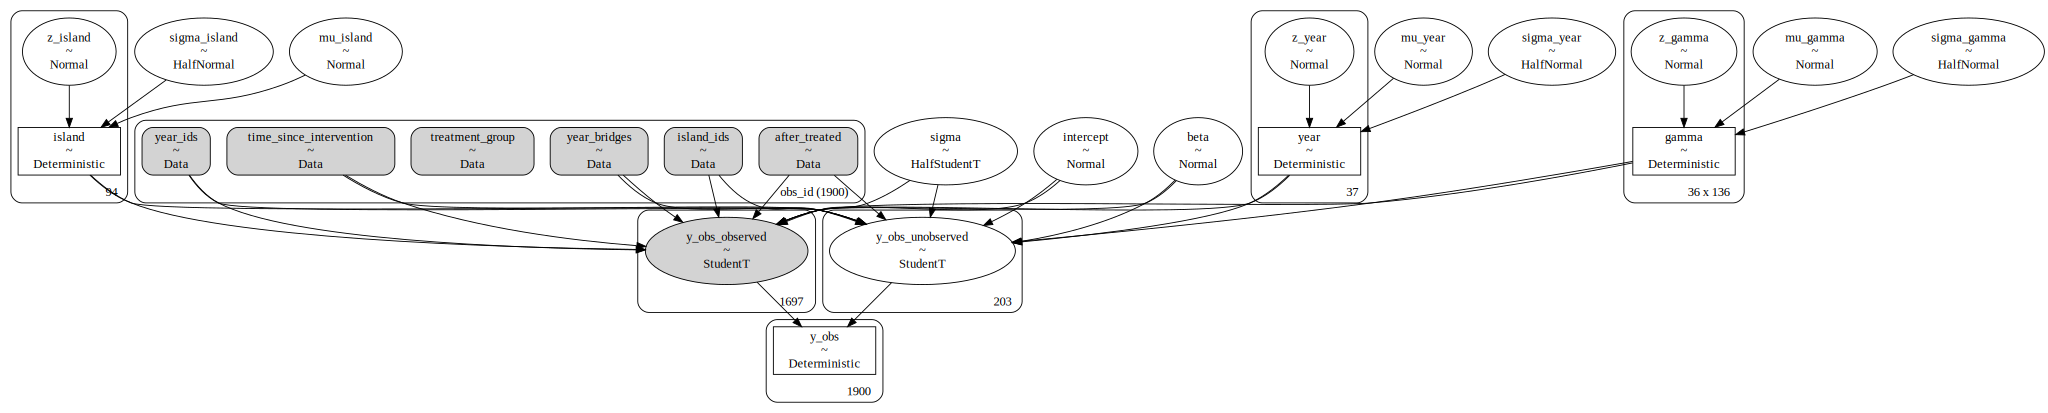

In [26]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_year_ids = pd.factorize(df['years'])
df['year_bridges_opened'], unique_year_bridges_opened = pd.factorize(df['year_bridges_opened'])
unique_time_since_intervention = len(df['time_since_intervention'].unique())
unique_year_bridges_opened = len(df['year_bridges_opened'].unique())

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as fully_saturated_h:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['years'], dims='obs_id')
    after_treated = pm.Data('after_treated', df['after_treated'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'], dims='obs_id')
    year_bridges = pm.Data('year_bridges', df['year_bridges_opened'], dims='obs_id')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=1)
    sigma_island = pm.HalfNormal('sigma_island', sigma=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, shape=len(unique_island_ids))
    island = pm.Deterministic('island', mu_island + sigma_island * z_island)

    mu_year = pm.Normal('mu_year', mu=0, sigma=1)
    sigma_year = pm.HalfNormal('sigma_year', sigma=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, shape=len(unique_year_ids))
    year = pm.Deterministic('year', mu_year + sigma_year * z_year)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=1)
    sigma_gamma = pm.HalfNormal('sigma_gamma', sigma=1)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=1, shape=(unique_year_bridges_opened, unique_time_since_intervention))
    gamma = pm.Deterministic('gamma', mu_gamma + sigma_gamma * z_gamma)

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + (beta + gamma[year_bridges, time_since_intervention]) * after_treated + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(fully_saturated_h)

In [28]:
with fully_saturated_h:
    trace_fully_saturated_h = pm.sample(
        draws=1000,
        tune=500,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )
    pm.compute_log_likelihood(trace_fully_saturated_h)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [32]:
az.summary(trace_fully_saturated_h, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.996,0.805,0.418,3.584,0.036,0.025,507.0,941.0,1.01
beta,0.104,0.729,-1.320,1.510,0.039,0.027,357.0,647.0,1.00
sigma,0.115,0.003,0.109,0.121,0.000,0.000,654.0,1147.0,1.00


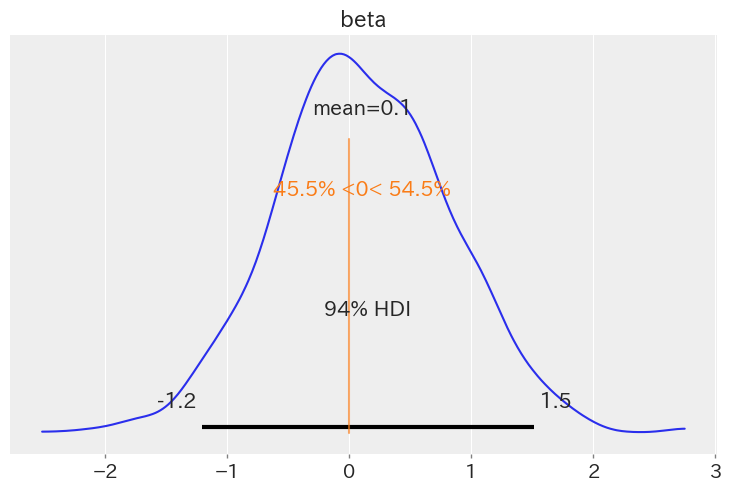

In [40]:
az.plot_posterior(trace_fully_saturated_h, var_names=['beta'], ref_val=0);

In [31]:
az.waic(trace_fully_saturated_h)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   429.81    56.49
p_waic      155.79        -

There has been a warning during the calculation. Please check the results.

## サンプリングの保存

In [29]:
az.to_netcdf(trace_fully_saturated, './sample/trace_fully_saturated_log.nc')
az.to_netcdf(trace_fully_saturated_h, './sample/trace_fully_saturated_h_log.nc')

'./sample/trace_fully_saturated_h_log.nc'

## サンプリングのインポート

In [4]:
trace_fully_saturated = az.from_netcdf('./sample/trace_fully_saturated_log.nc')
trace_fully_saturated_h = az.from_netcdf('./sample/trace_fully_saturated_h_log.nc')

## ランダム効果の可視化

In [18]:
def get_gamma_df(trace):
    # デルタのサマリーを取得
    gamma_df = az.summary(trace, var_names=['gamma'], hdi_prob=0.95, kind='stats')

    # 正規表現を使用してインデックスから介入年と経過年数を抽出
    extracted = gamma_df.index.to_series().str.extract(r'gamma\[(\d+),\s*(\d+)\]')
    gamma_df['treat'] = extracted[0].astype(int)
    gamma_df['ell'] = extracted[1].astype(int)

    df = pd.read_excel(filepath)
    year_bridges_opened = df['year_bridges_opened'].unique()
    treat = gamma_df['treat'].unique()

    year_bridges_opened, treat

    gamma_df['treat'] = gamma_df['treat'].map(dict(enumerate(year_bridges_opened)))

    time_since_intervention = df['time_since_intervention'].unique()

    gamma_df['ell'] = gamma_df['ell'].map(dict(enumerate(time_since_intervention)))

    gamma_df['exp_mean'] = np.exp(gamma_df['mean']) - 1
    gamma_df['exp_hdi_2.5%'] = np.exp(gamma_df['hdi_2.5%']) - 1
    gamma_df['exp_hdi_97.5%'] = np.exp(gamma_df['hdi_97.5%']) - 1

    return gamma_df

In [19]:
def plot_delta_treat_log(gamma_df, treat):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='ell',
        y='mean',
        data=gamma_df[gamma_df['treat'] == treat],
        color='black',
        label='mean'
    )
    plt.errorbar(
        x=gamma_df[gamma_df['treat'] == treat]['ell'],
        y=gamma_df[gamma_df['treat'] == treat]['mean'],
        yerr=[
            gamma_df[gamma_df['treat'] == treat]['mean'] - gamma_df[gamma_df['treat'] == treat]['hdi_2.5%'],
            gamma_df[gamma_df['treat'] == treat]['hdi_97.5%'] - gamma_df[gamma_df['treat'] == treat]['mean']
        ],
        fmt='o',
        capsize=5,
        color='black',
        label='95% HDI'
    )
    plt.title(f'Treatment: {treat}')
    plt.legend()
    plt.show()

def plot_delta_treat_exp(gamma_df, treat):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='ell',
        y='exp_mean',
        data=gamma_df[gamma_df['treat'] == treat],
        color='black',
        label='mean'
    )
    plt.errorbar(
        x=gamma_df[gamma_df['treat'] == treat]['ell'],
        y=gamma_df[gamma_df['treat'] == treat]['exp_mean'],
        yerr=[
            gamma_df[gamma_df['treat'] == treat]['exp_mean'] - gamma_df[gamma_df['treat'] == treat]['exp_hdi_2.5%'],
            gamma_df[gamma_df['treat'] == treat]['exp_hdi_97.5%'] - gamma_df[gamma_df['treat'] == treat]['exp_mean']
        ],
        fmt='o',
        capsize=5,
        color='black',
        label='95% HDI'
    )
    plt.title(f'Treatment: {treat}')
    plt.legend()
    plt.show()

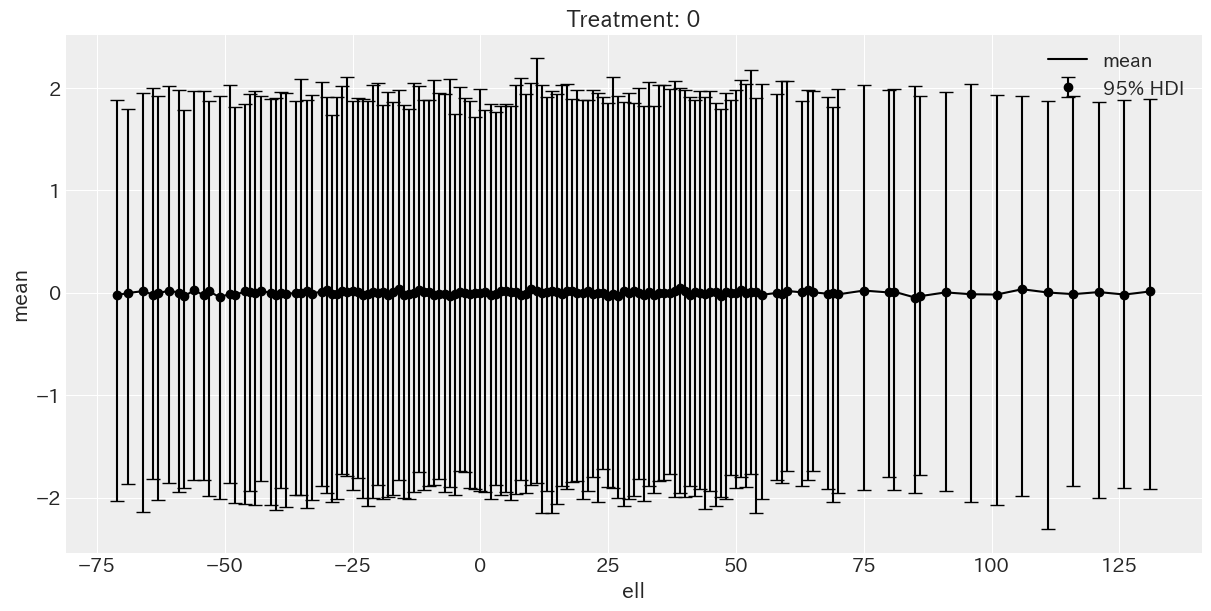

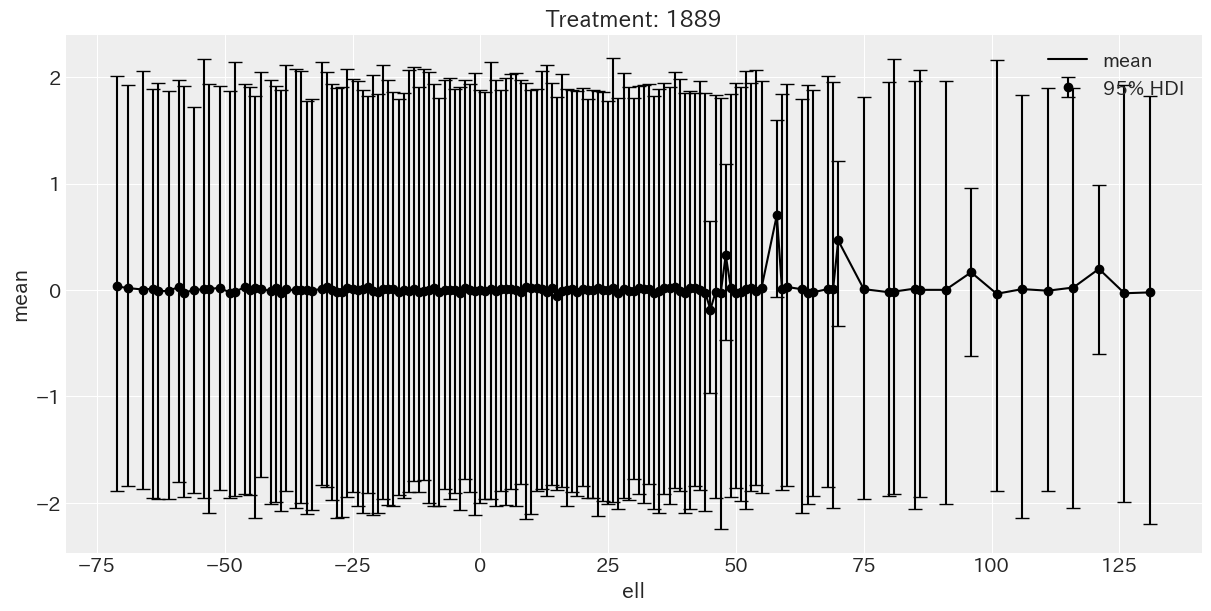

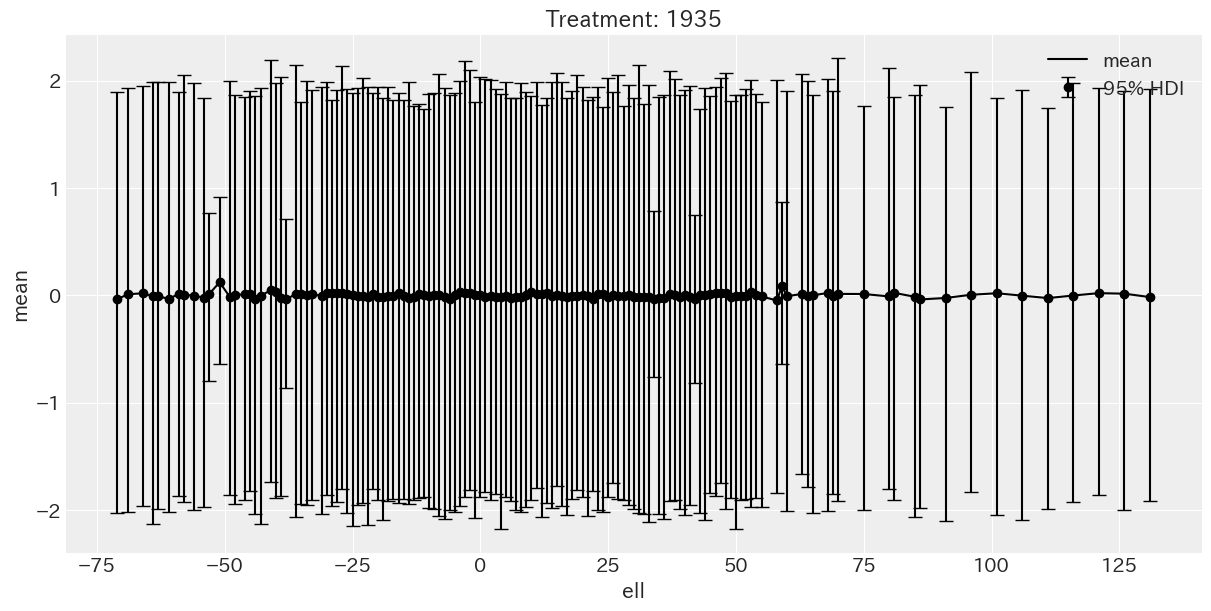

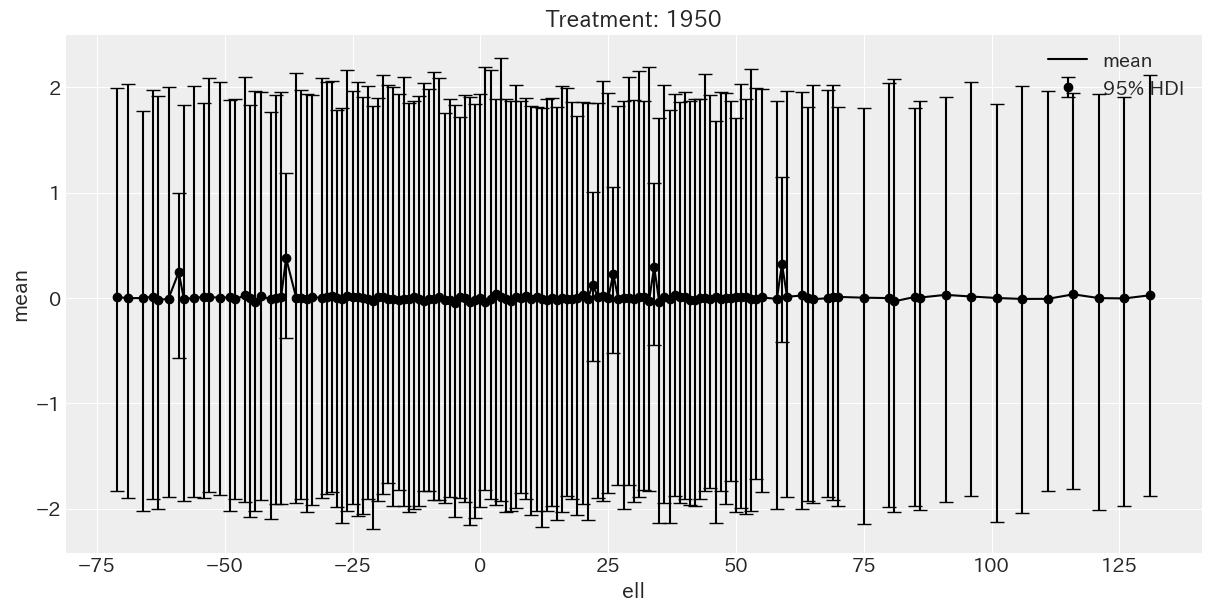

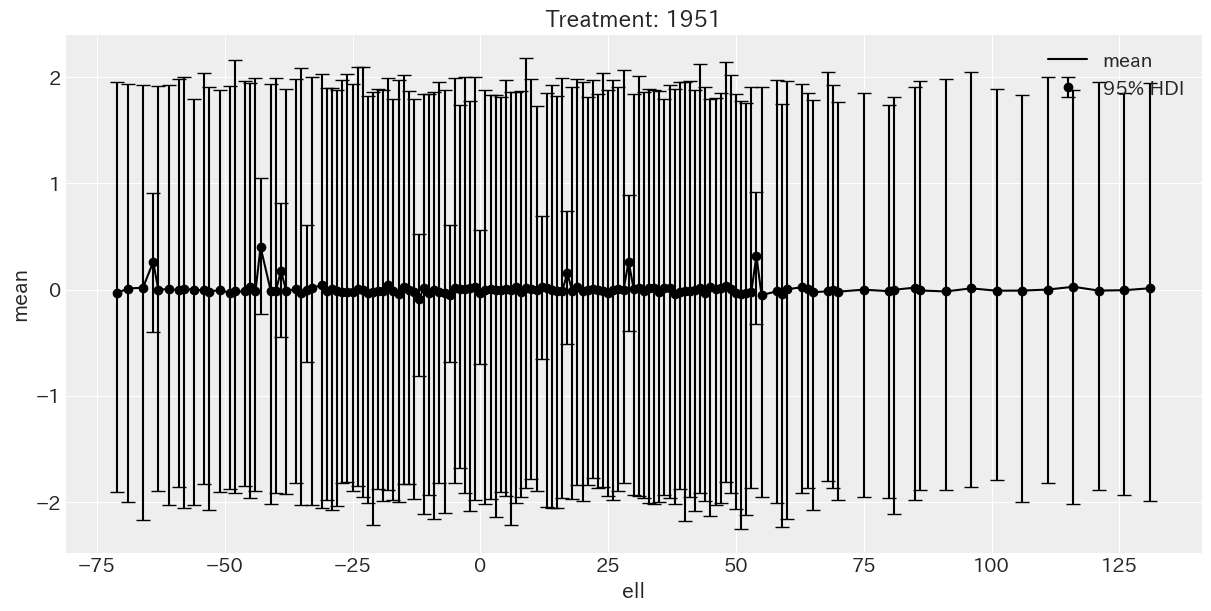

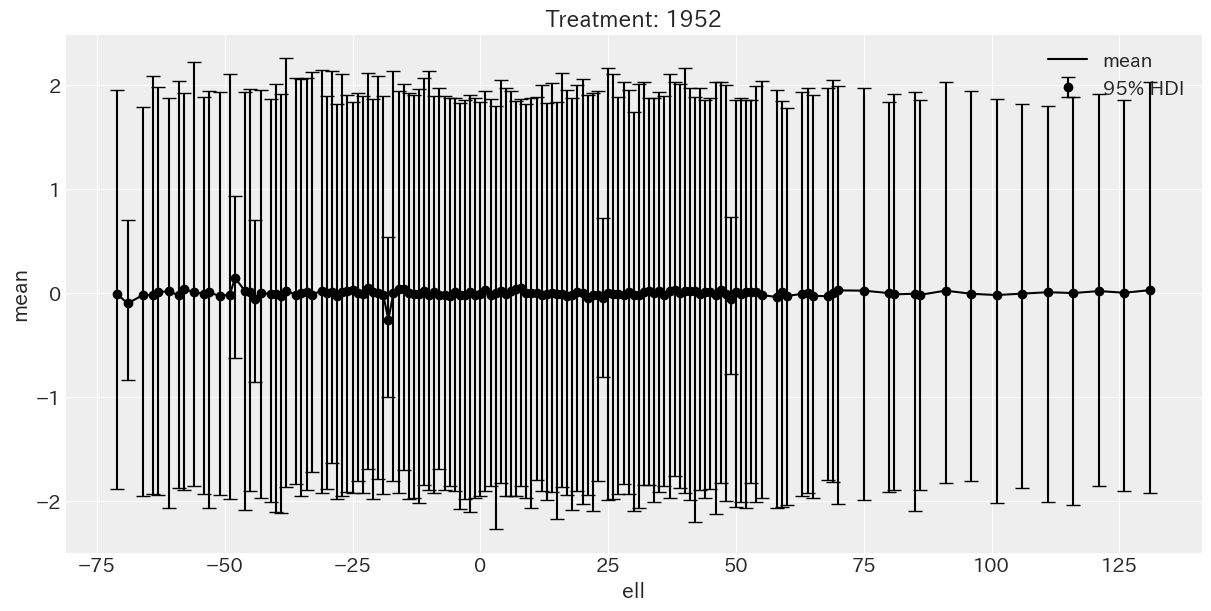

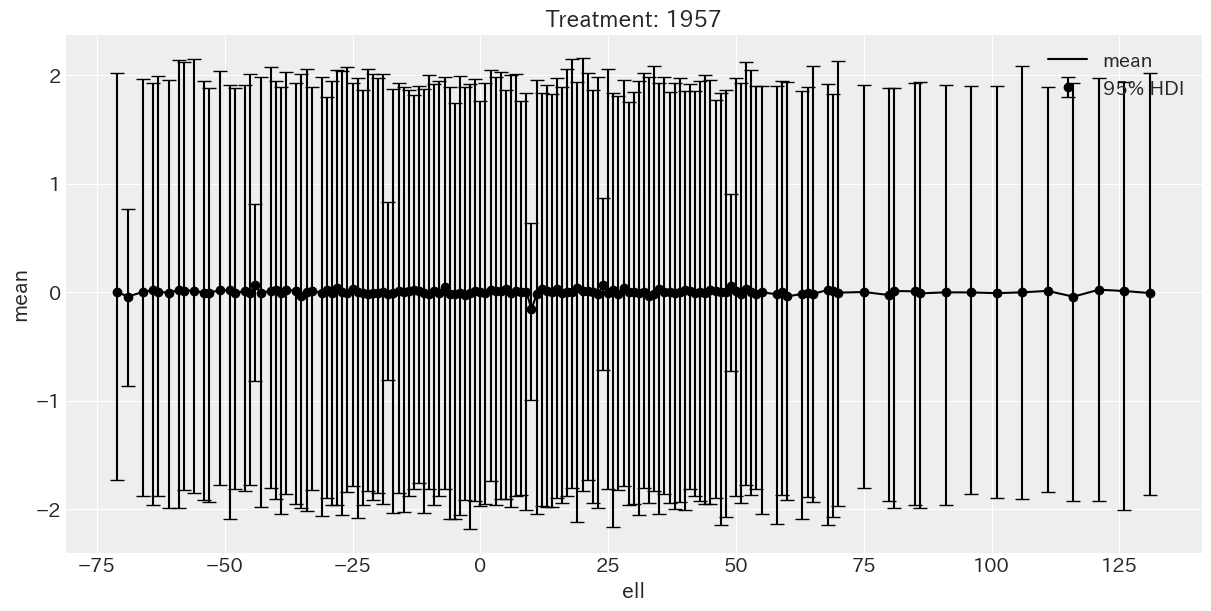

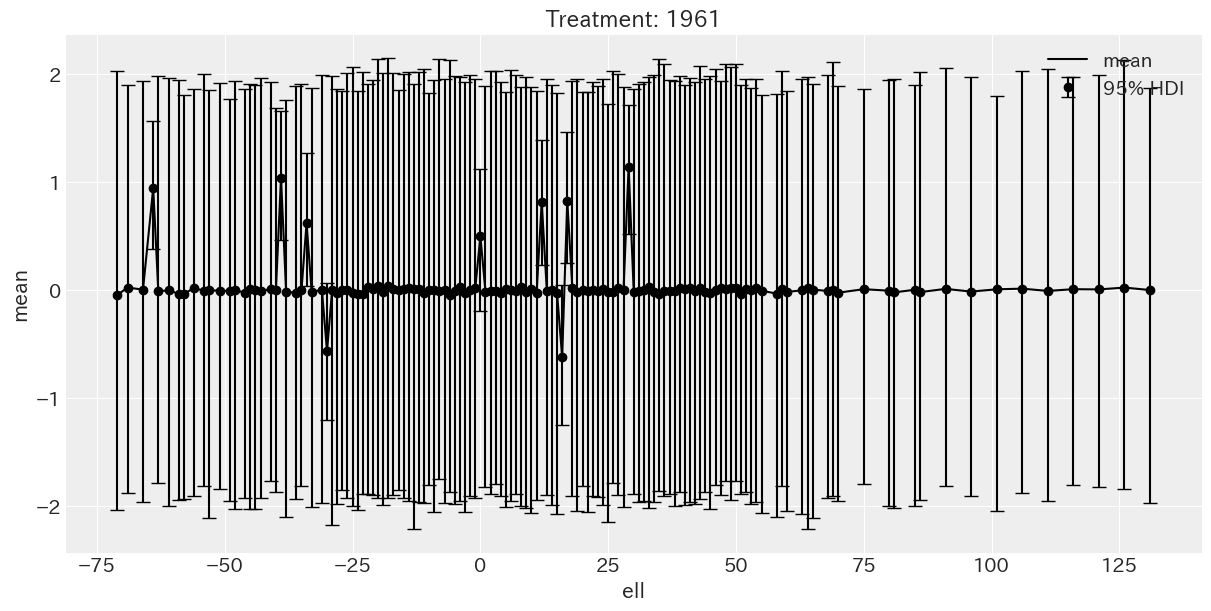

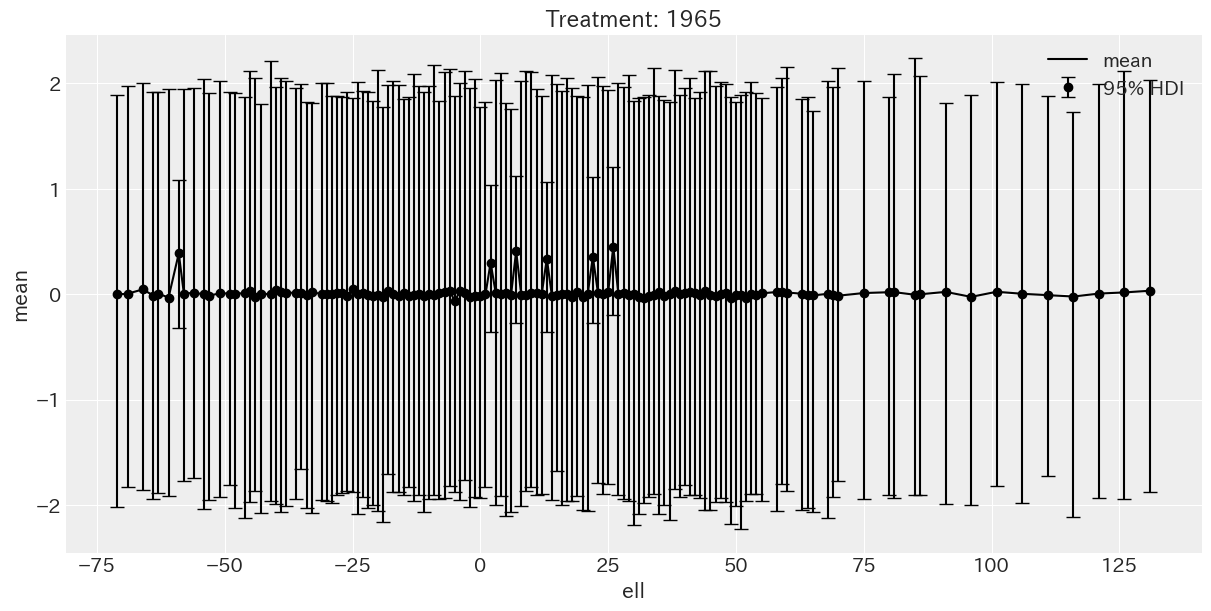

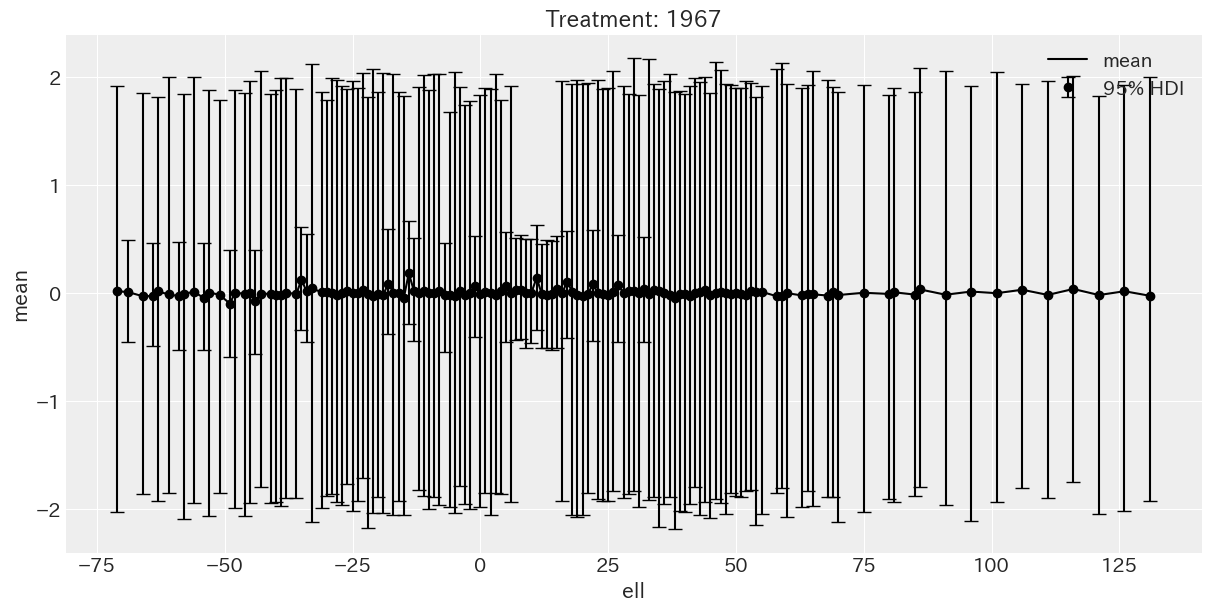

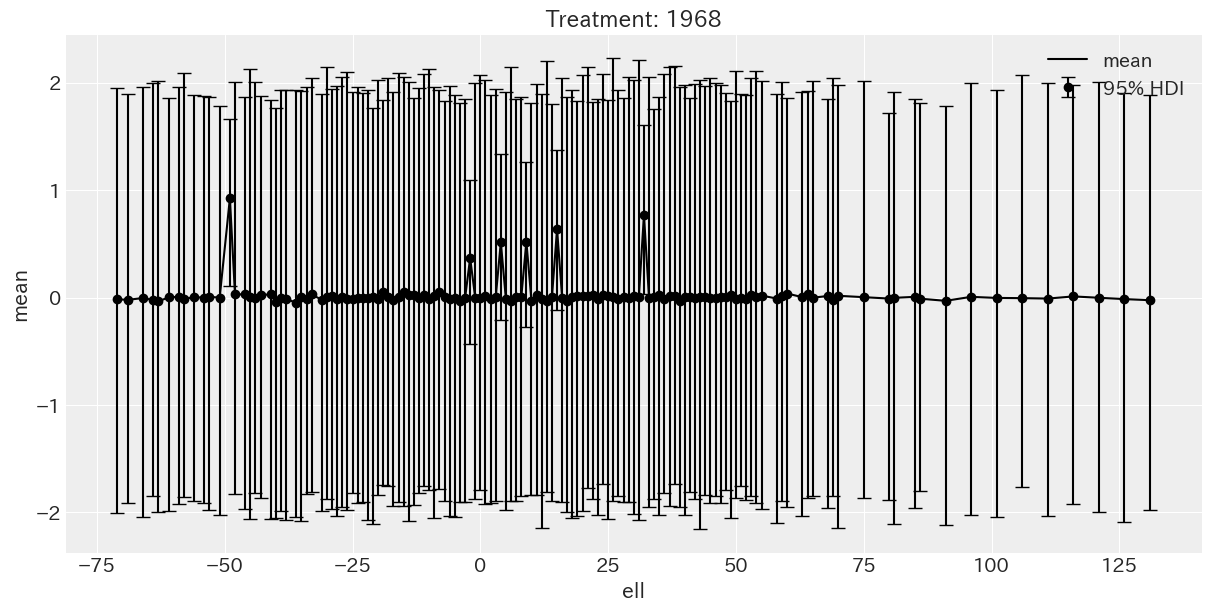

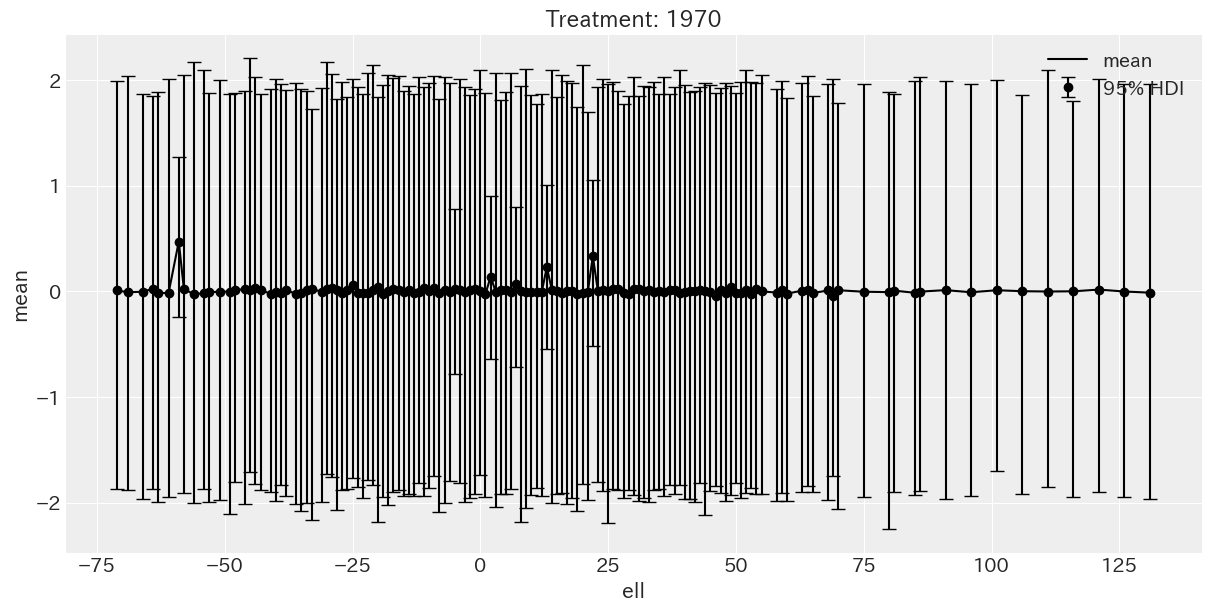

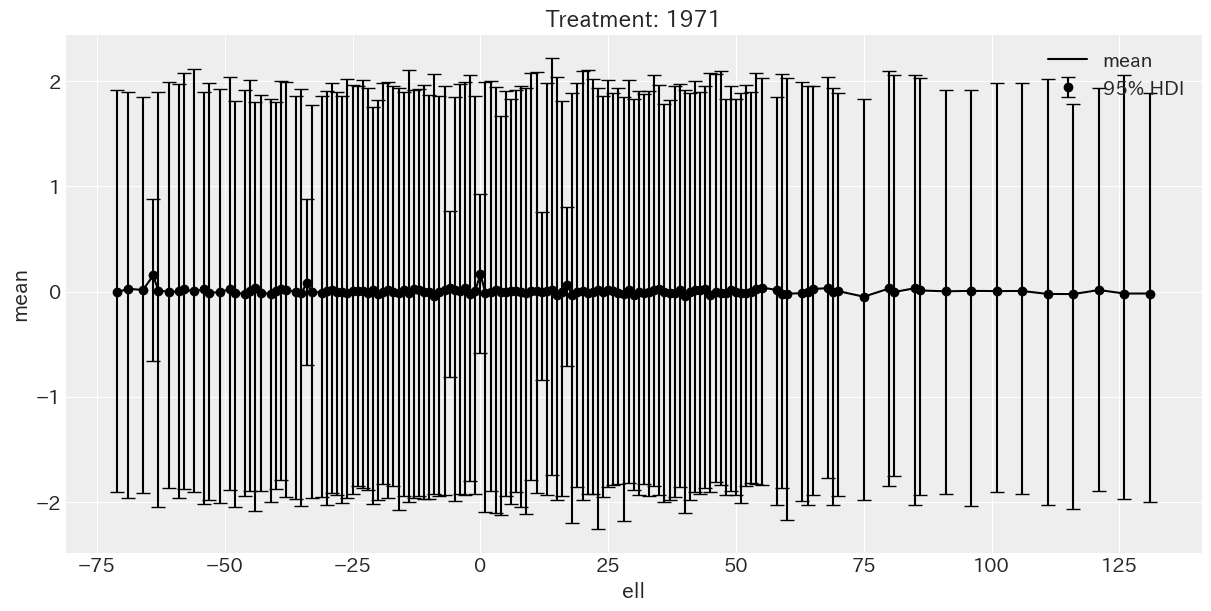

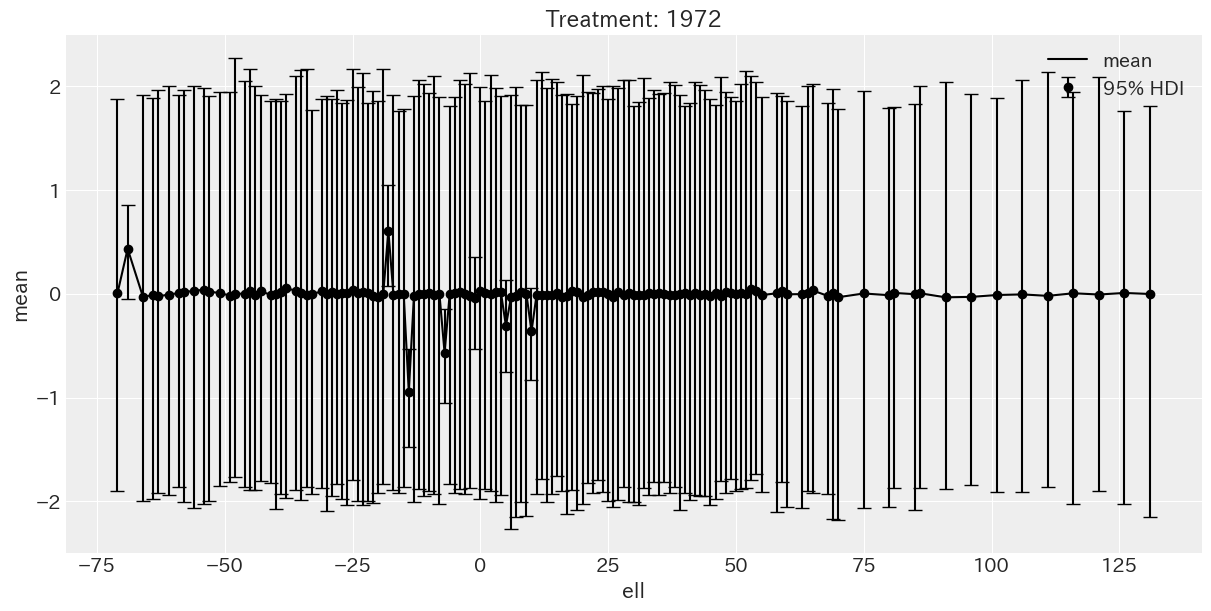

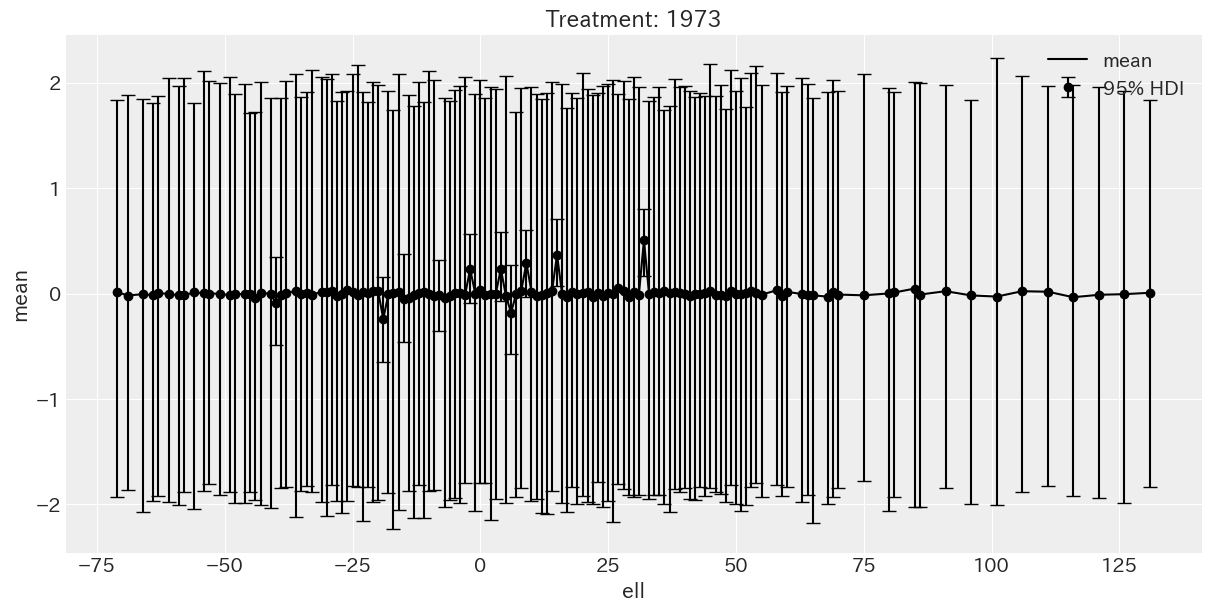

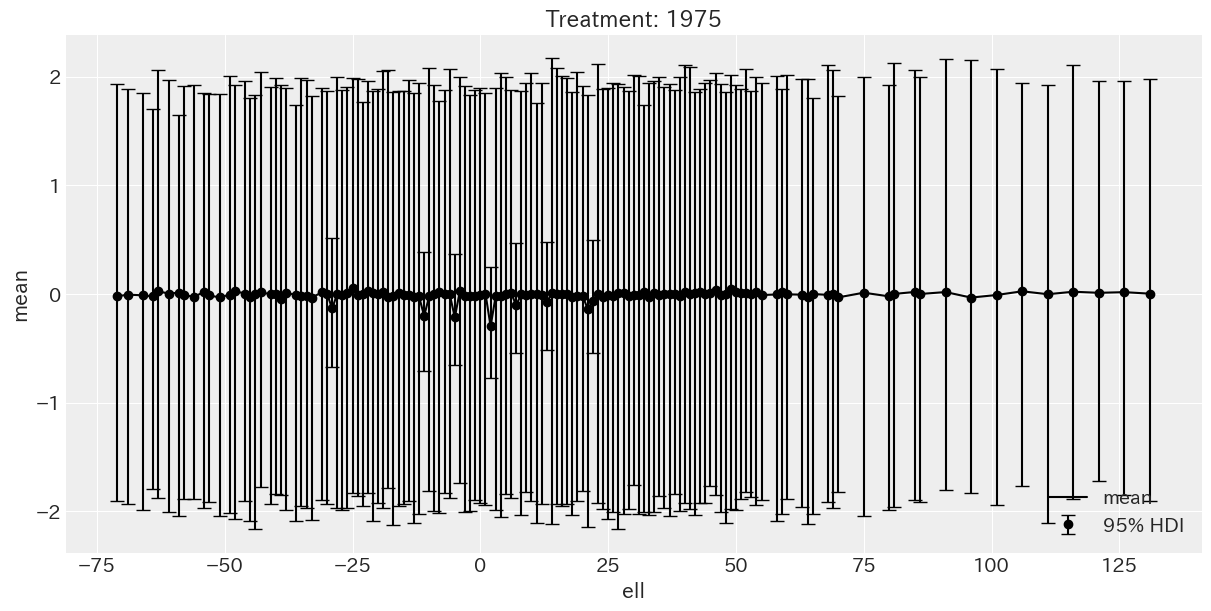

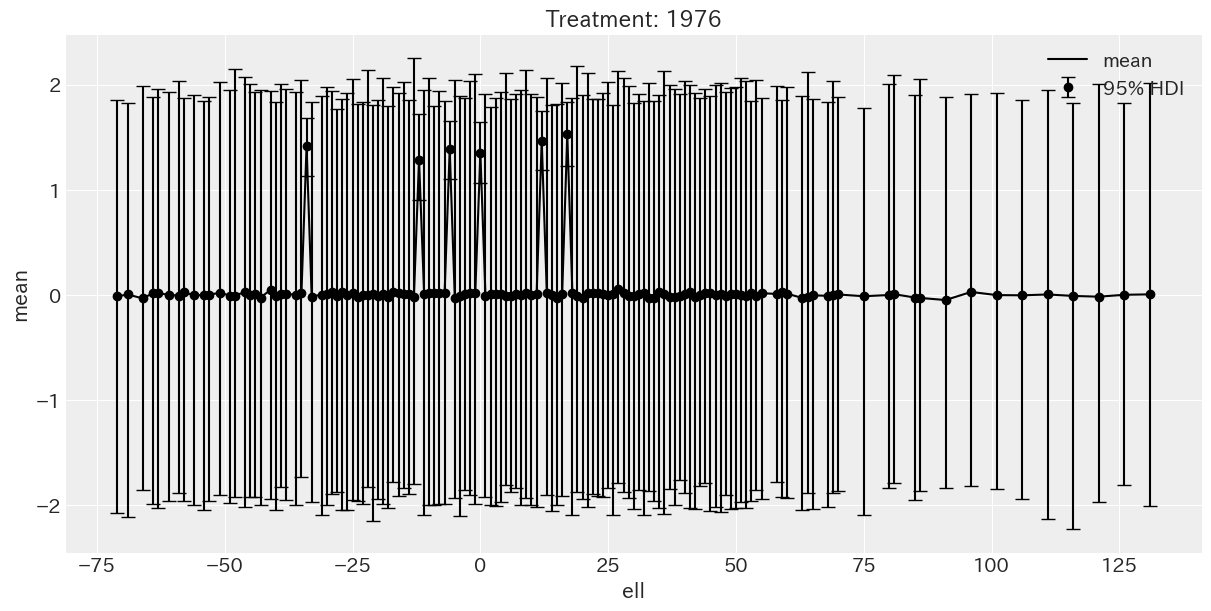

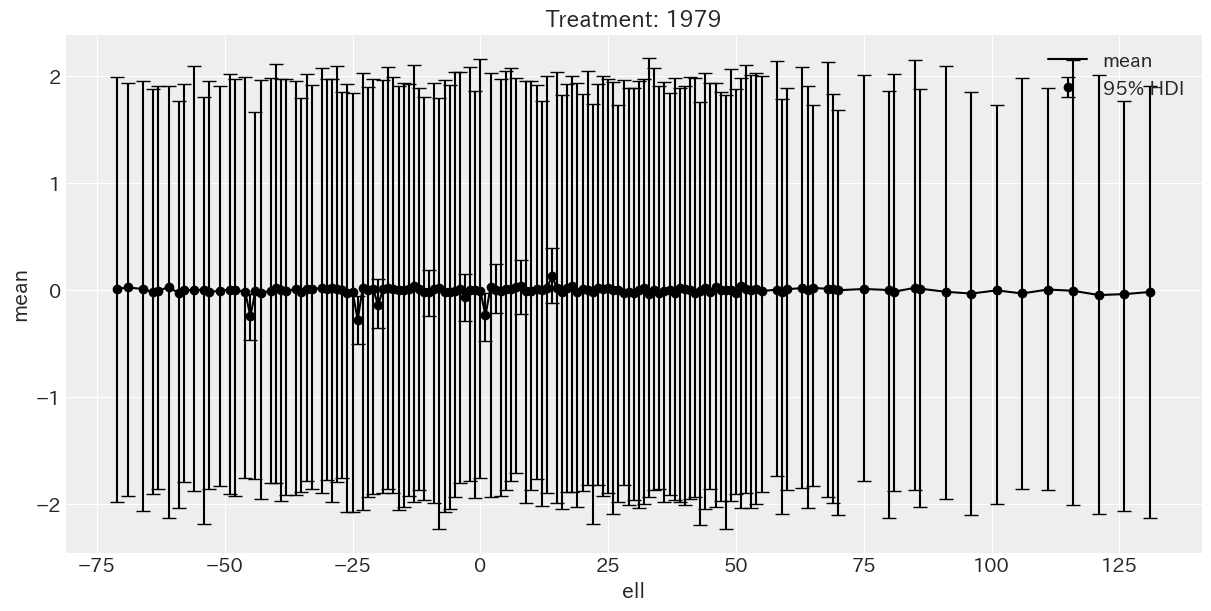

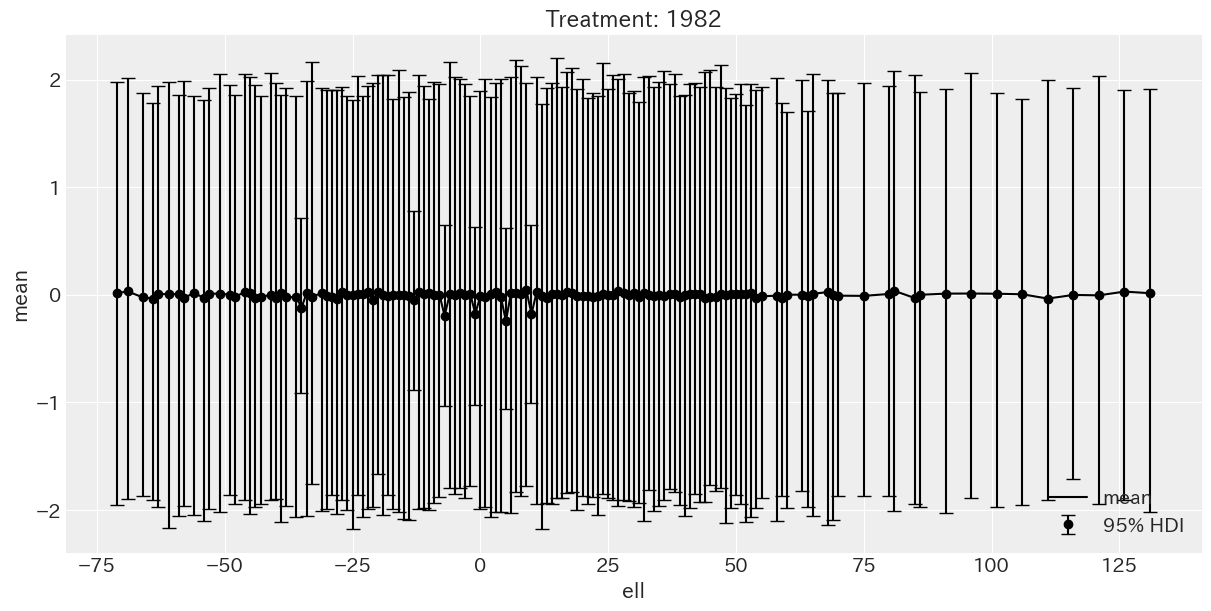

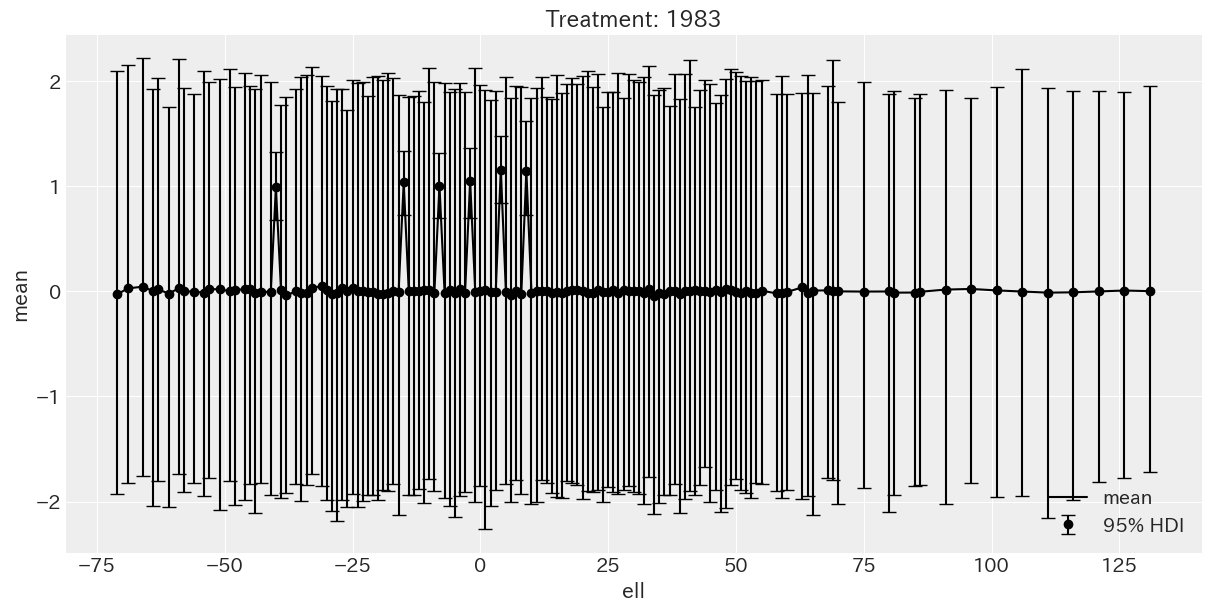

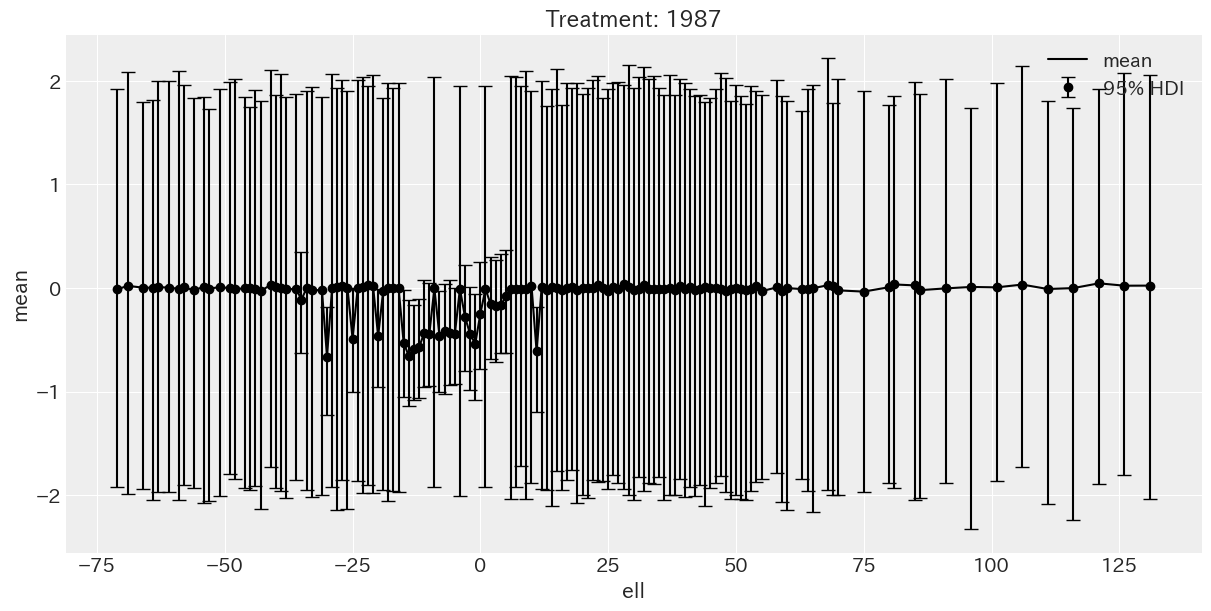

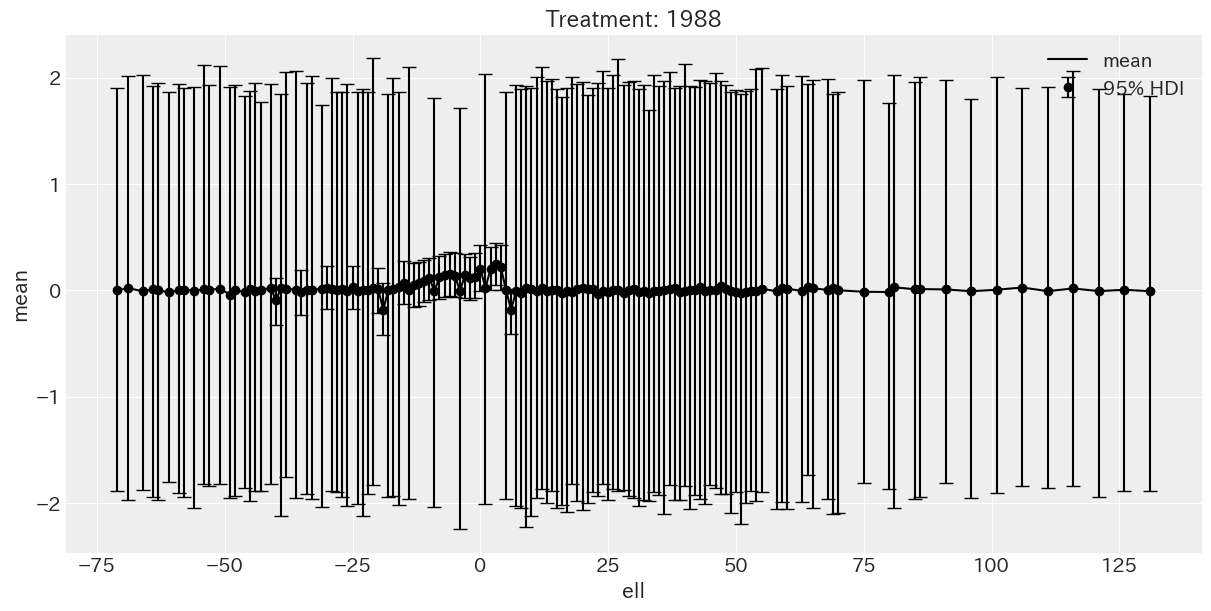

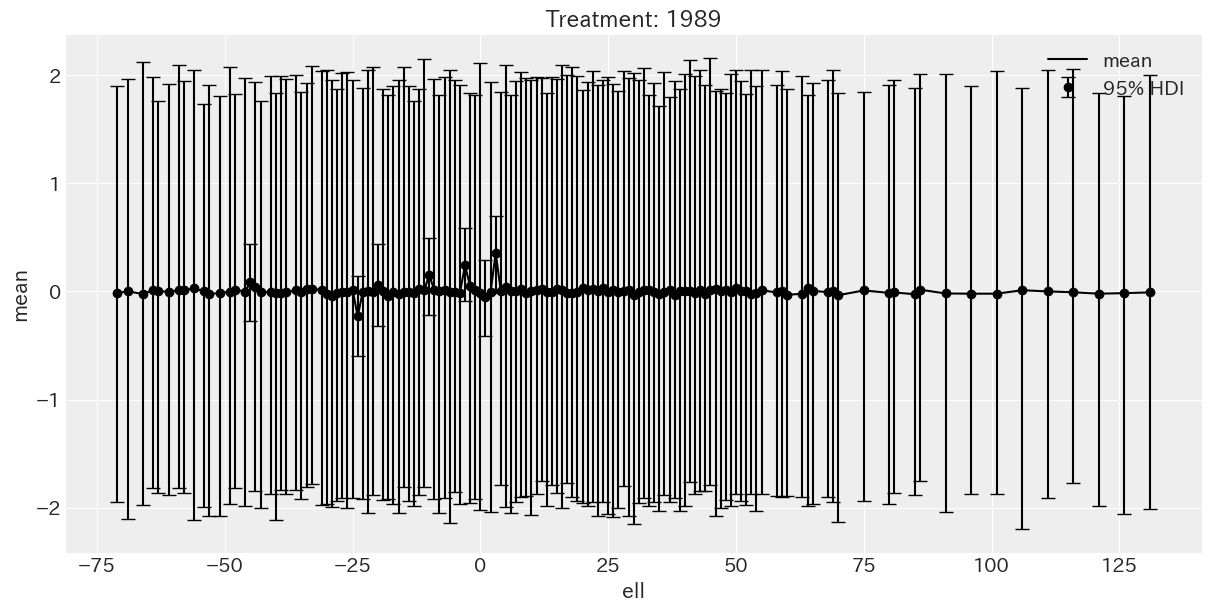

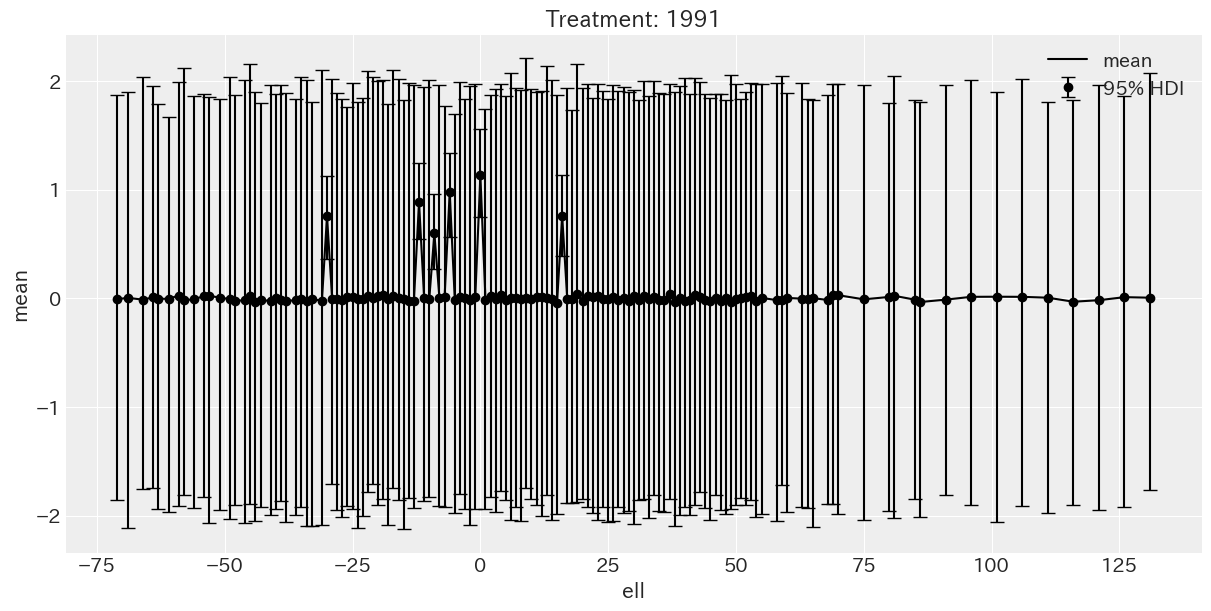

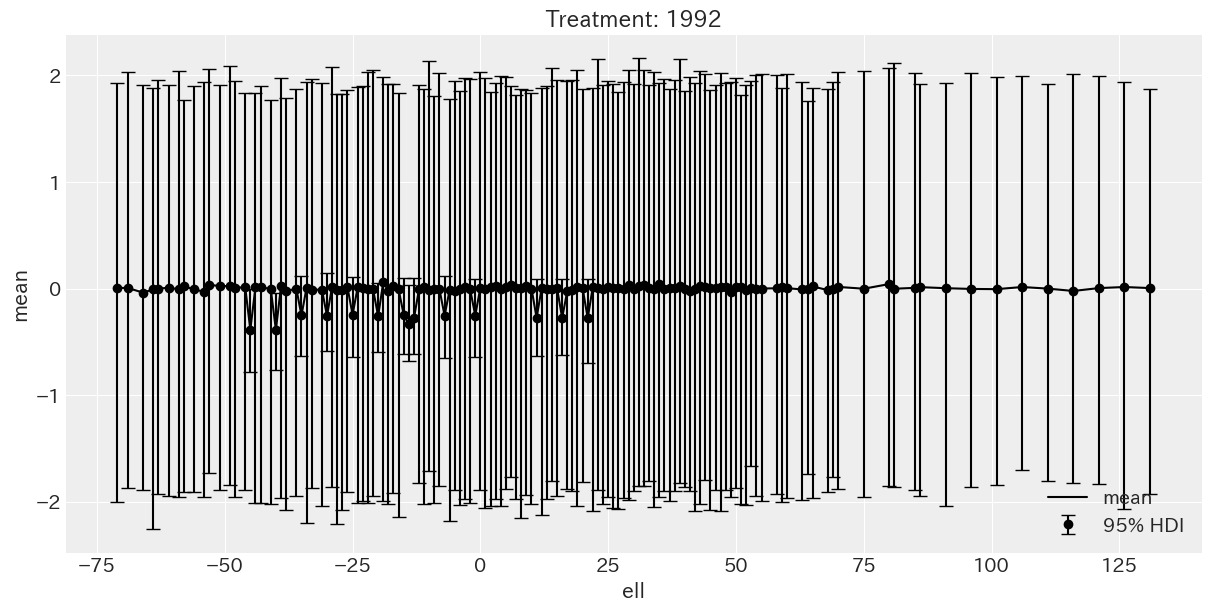

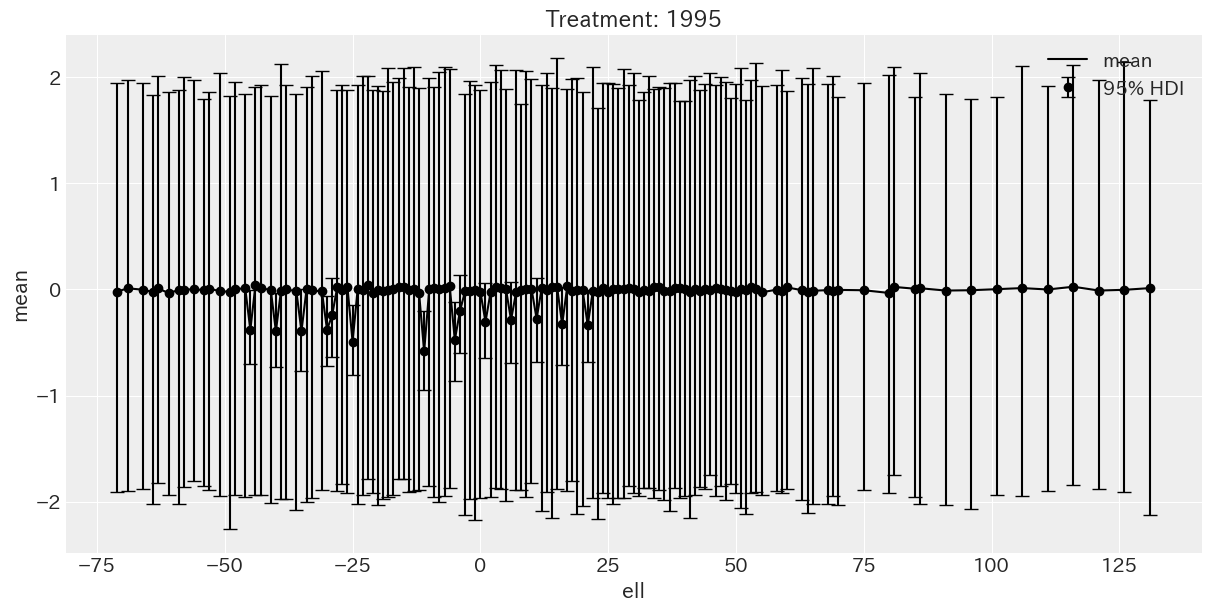

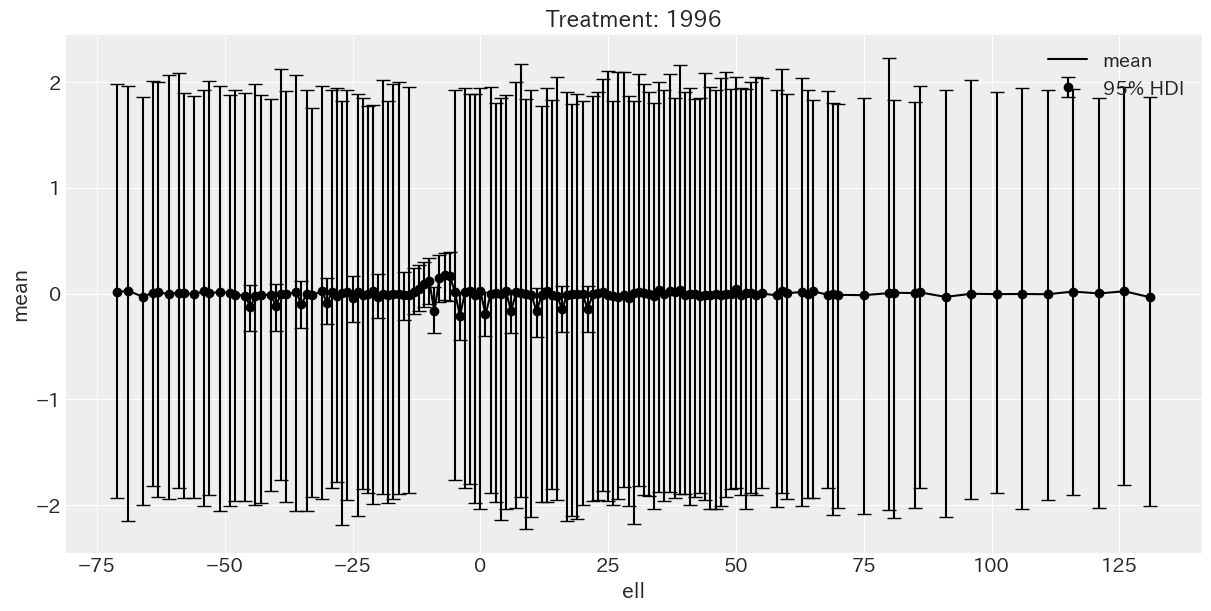

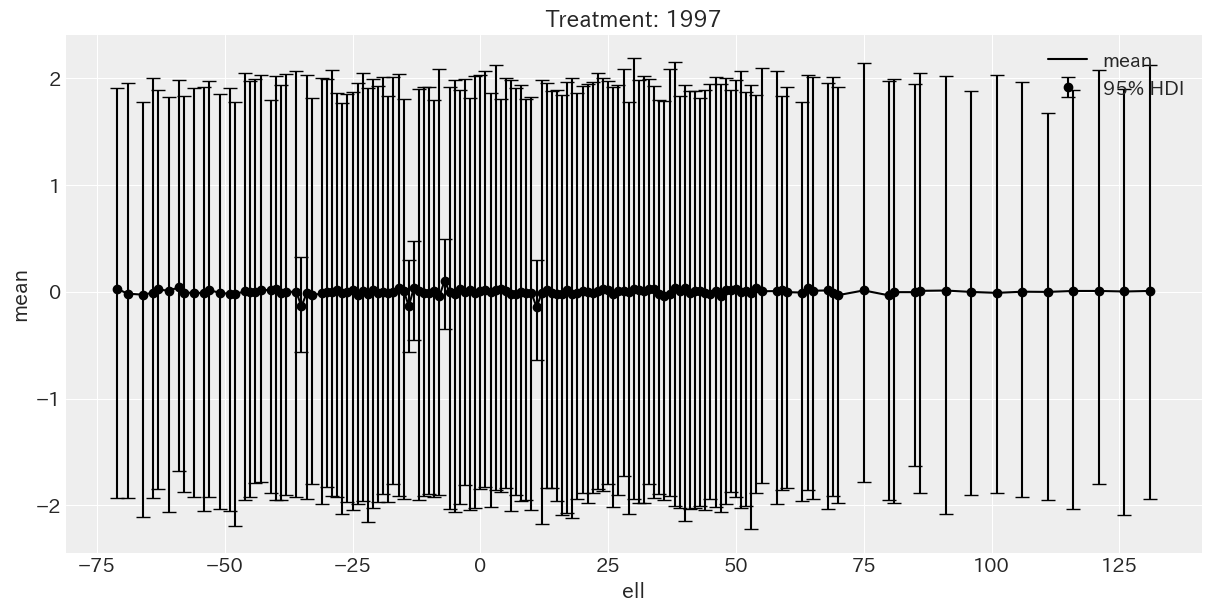

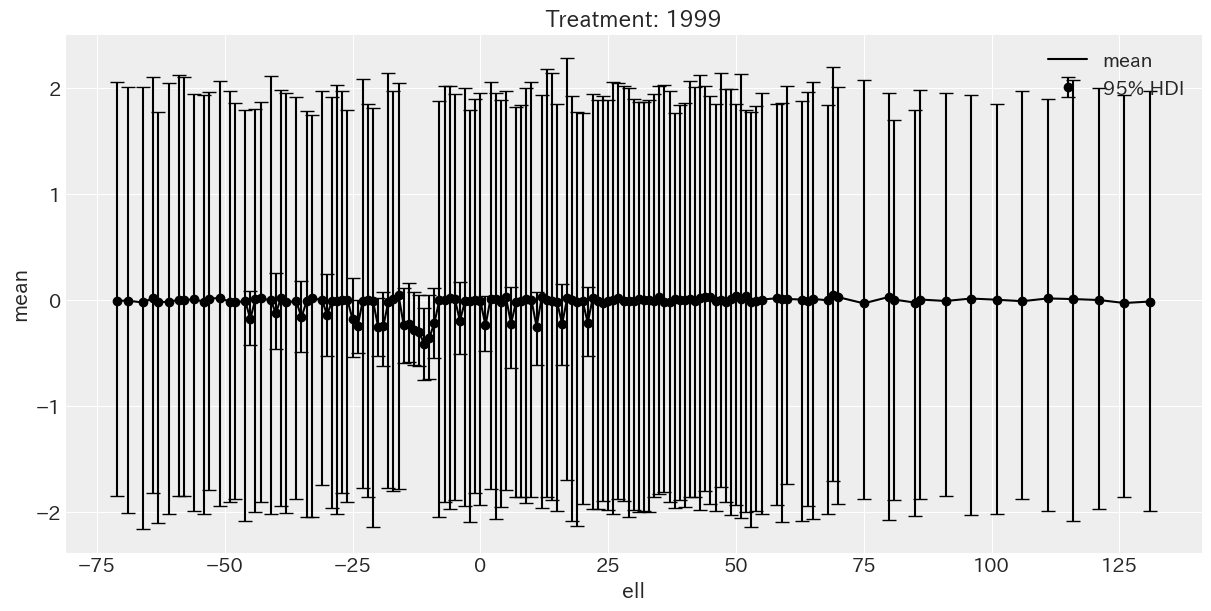

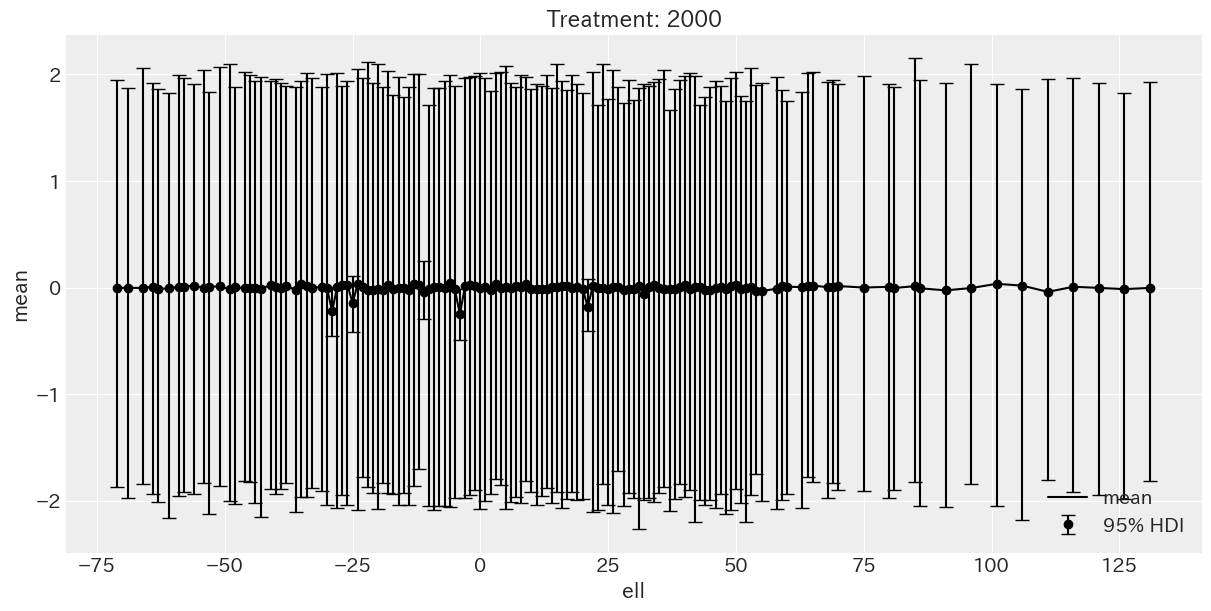

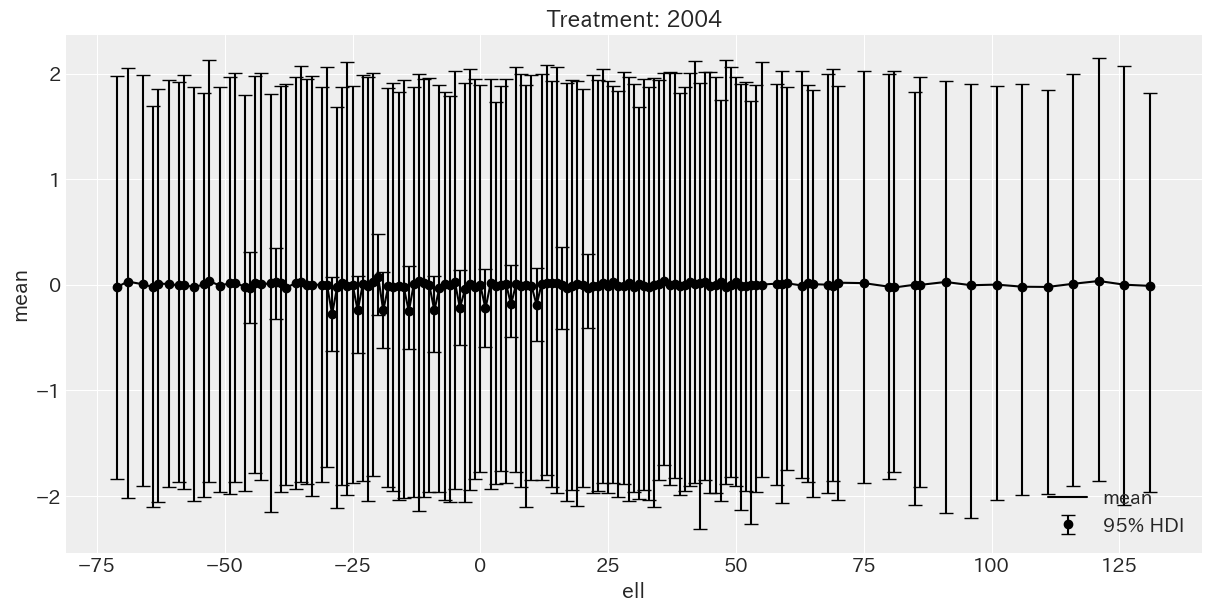

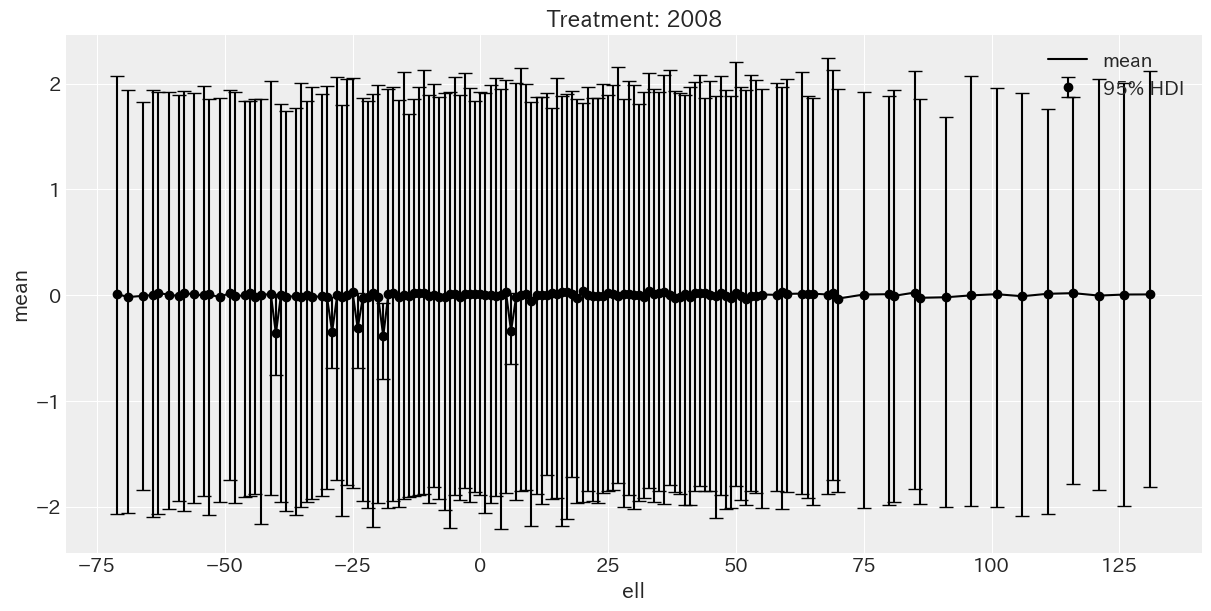

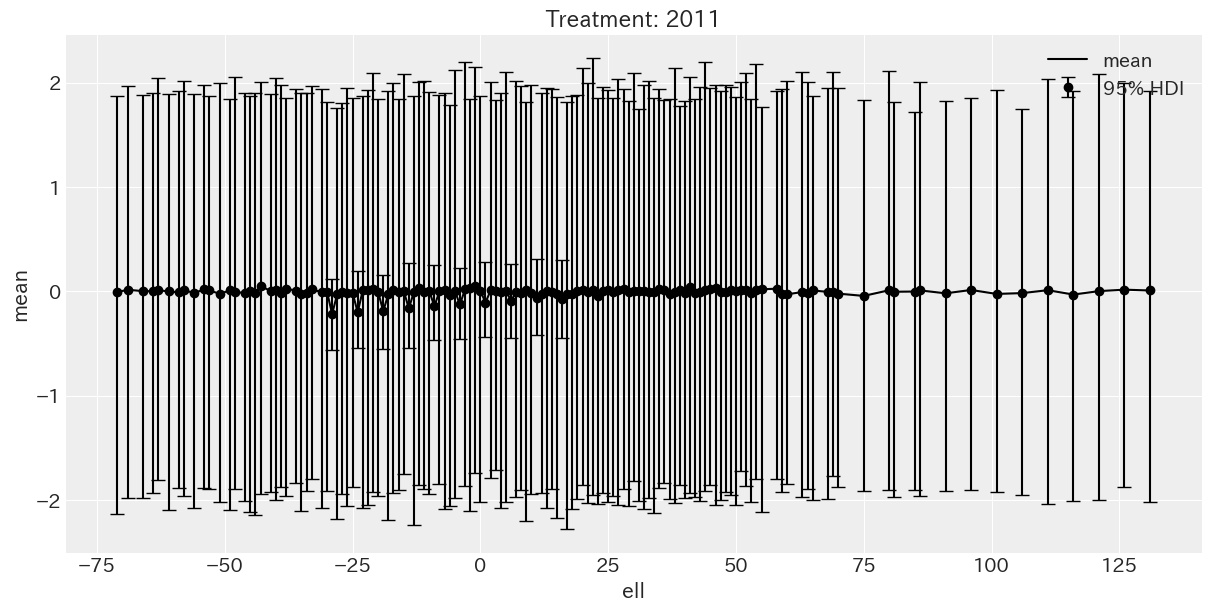

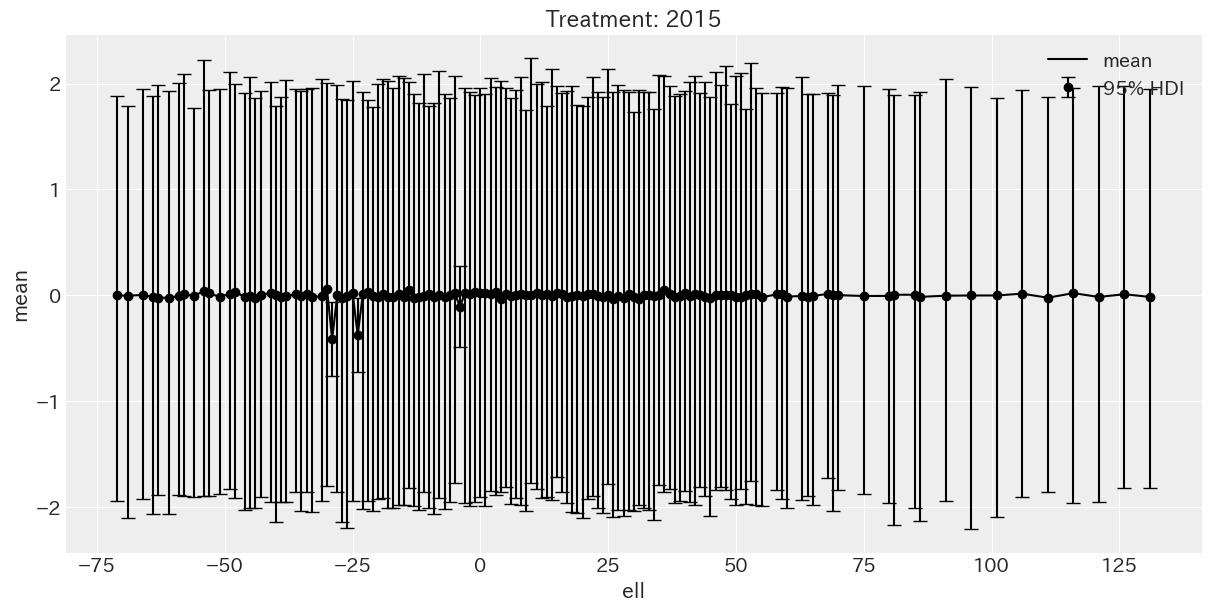

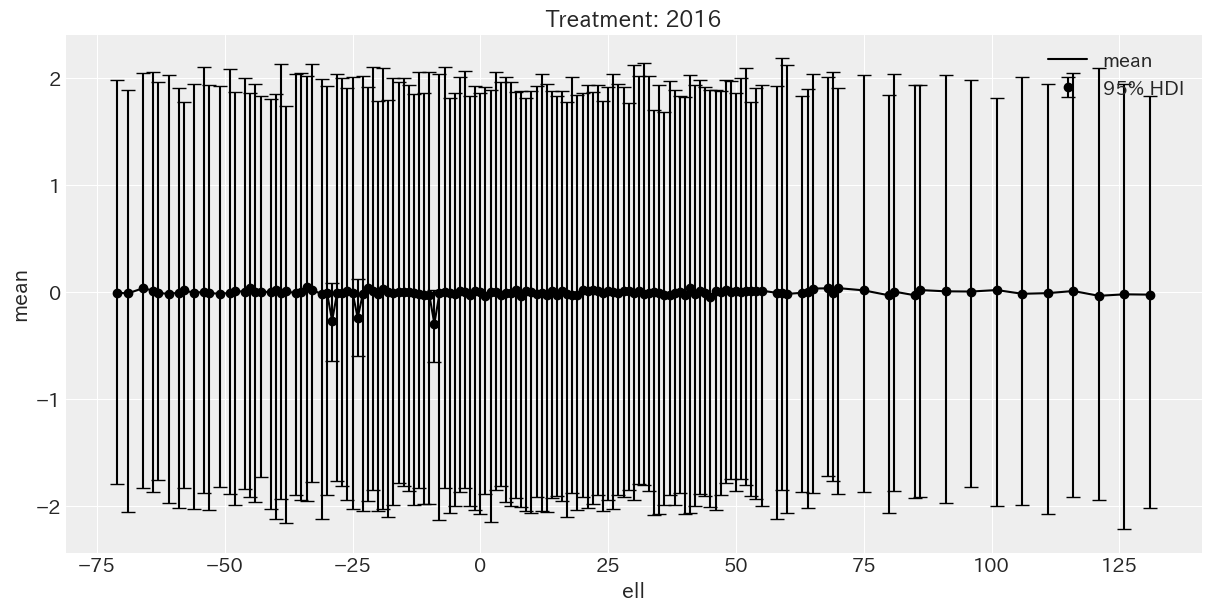

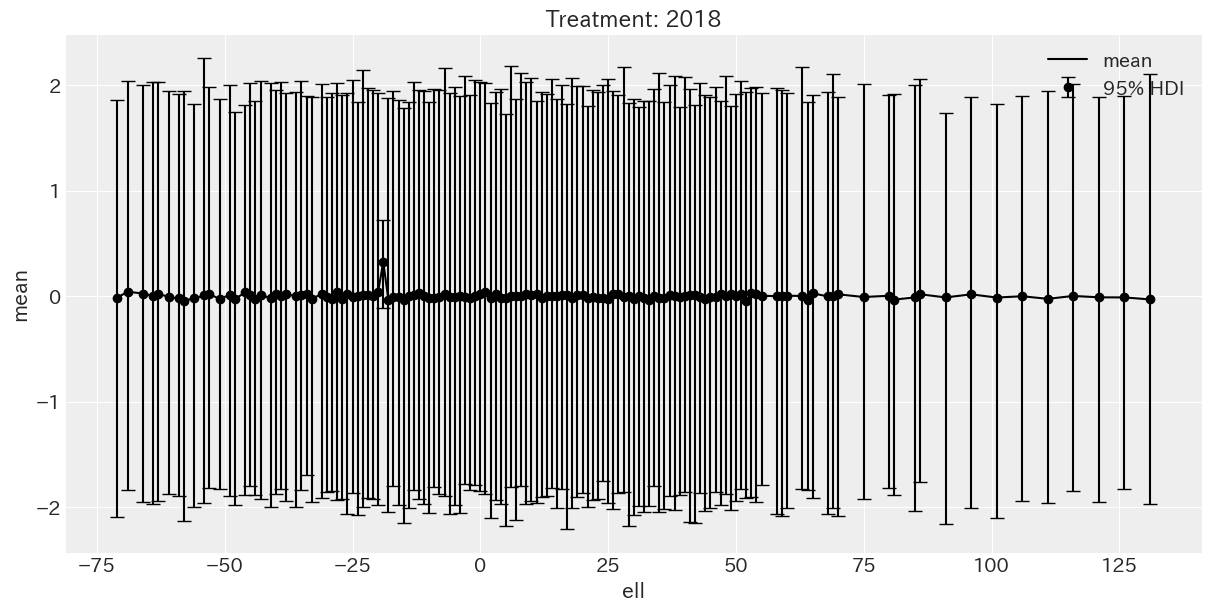

In [20]:

gamma_df = get_gamma_df(trace_fully_saturated)
treat_list = df['year_bridges_opened'].unique()
treat_list.sort()
for treat in treat_list:
    plot_delta_treat_log(gamma_df, treat)

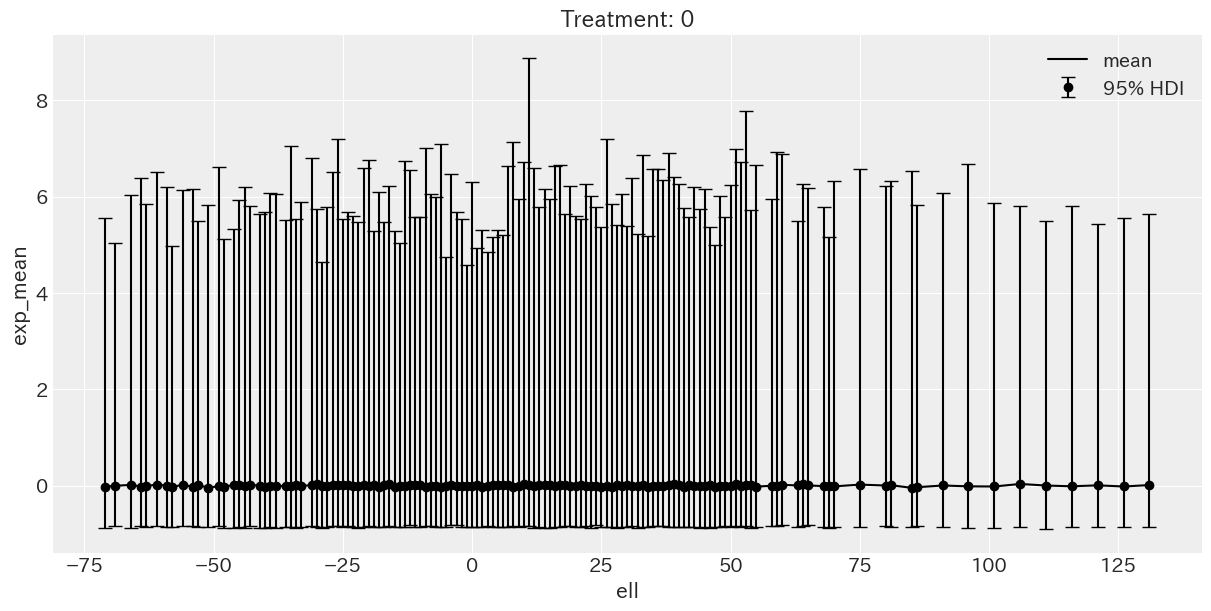

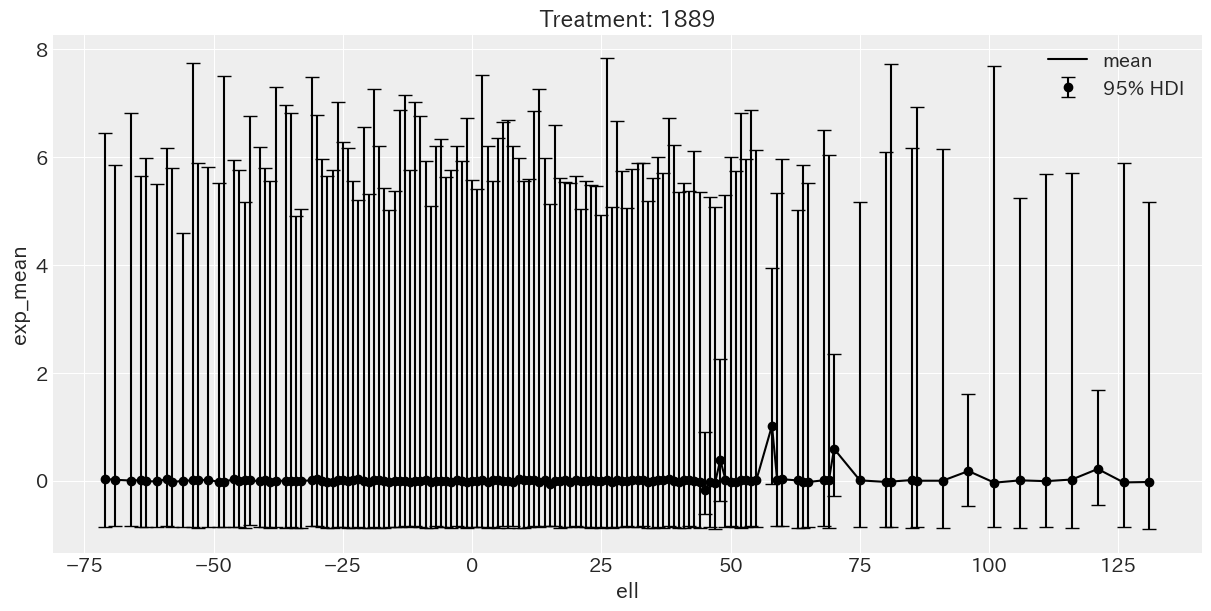

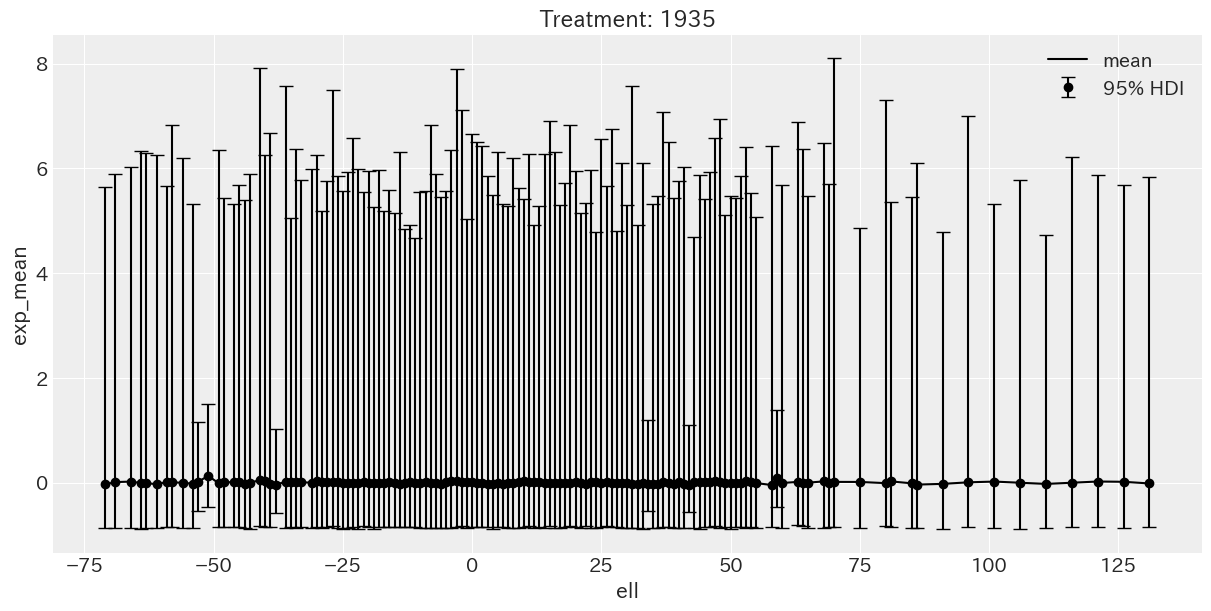

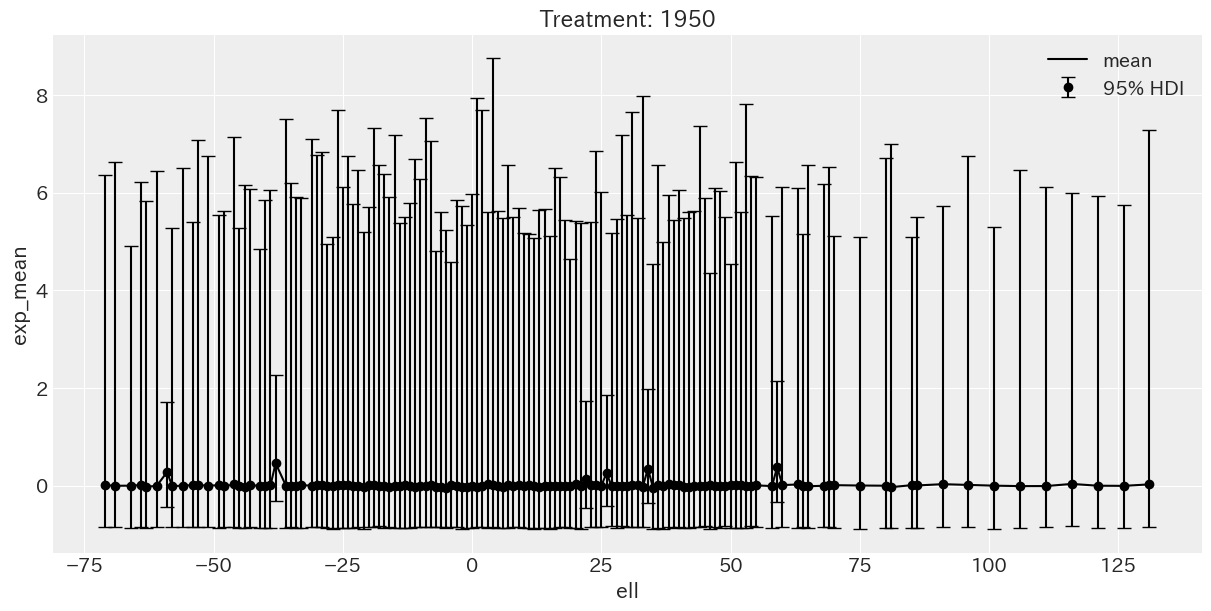

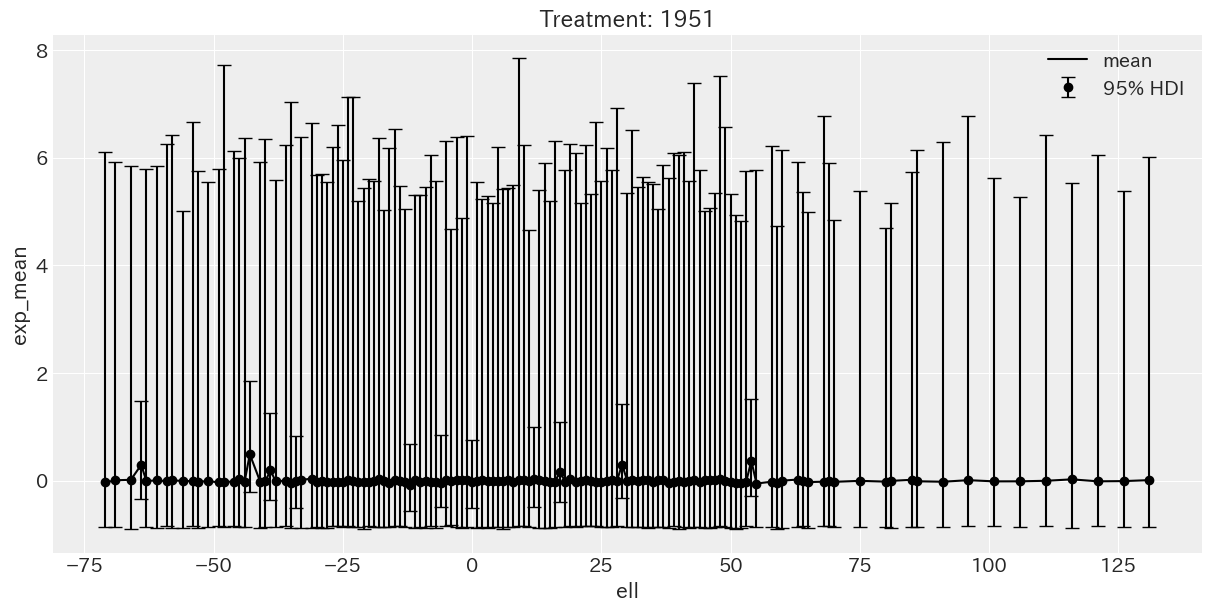

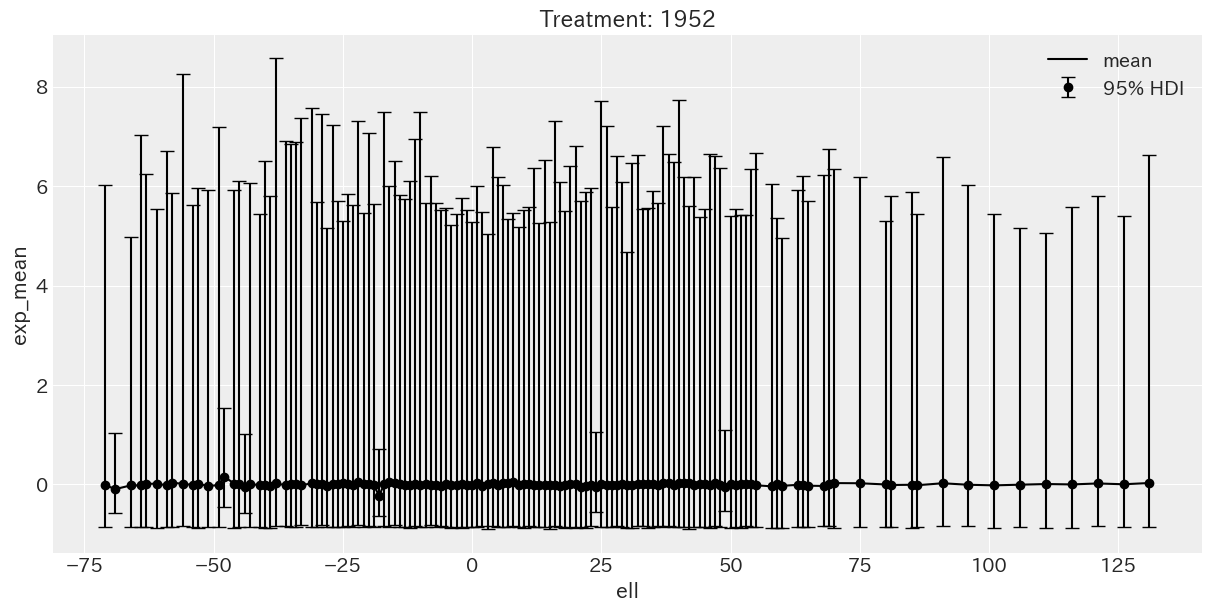

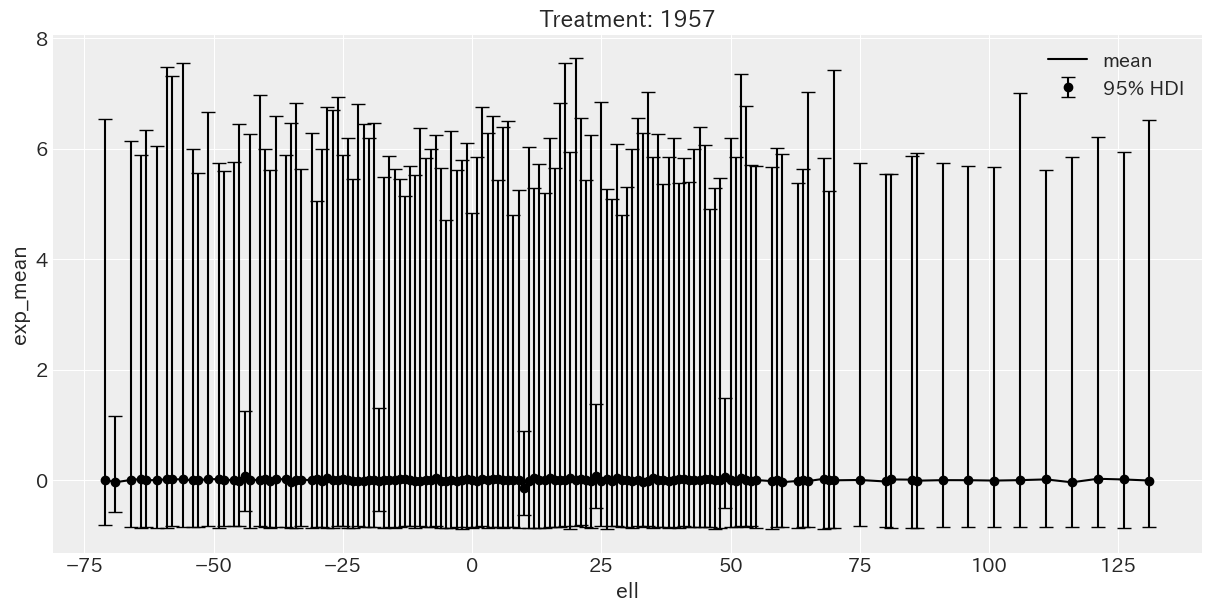

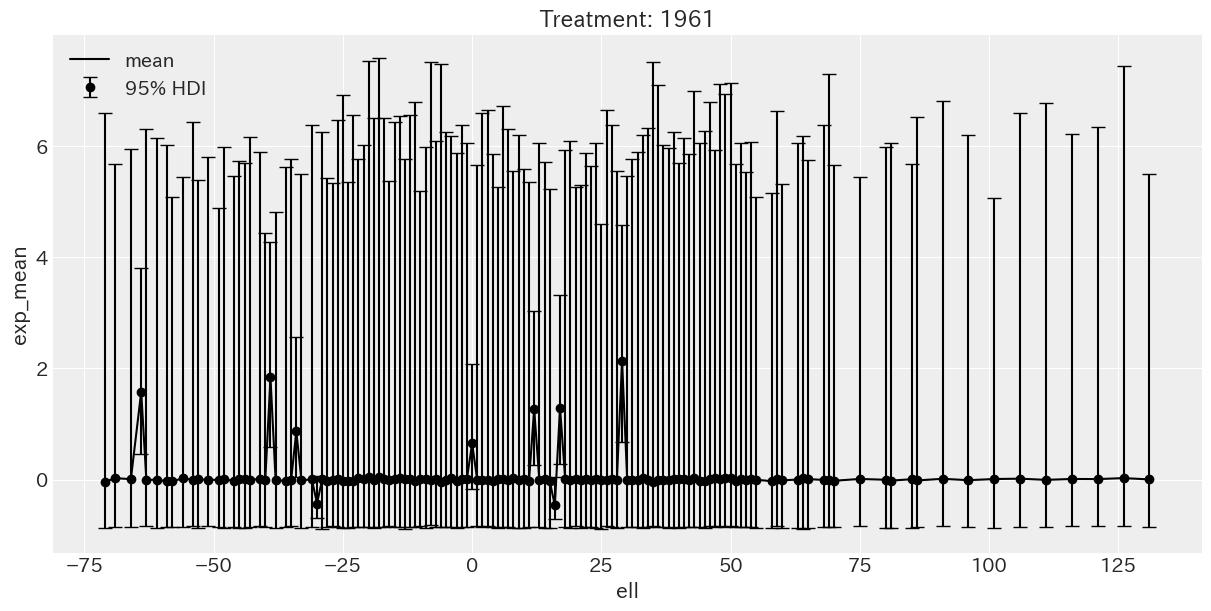

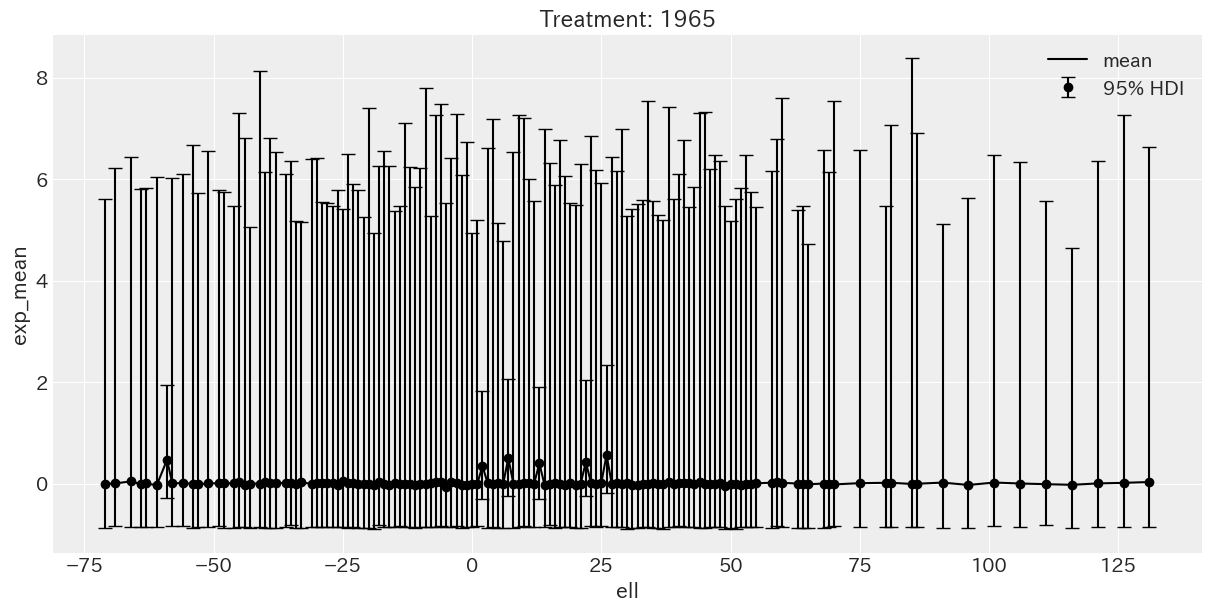

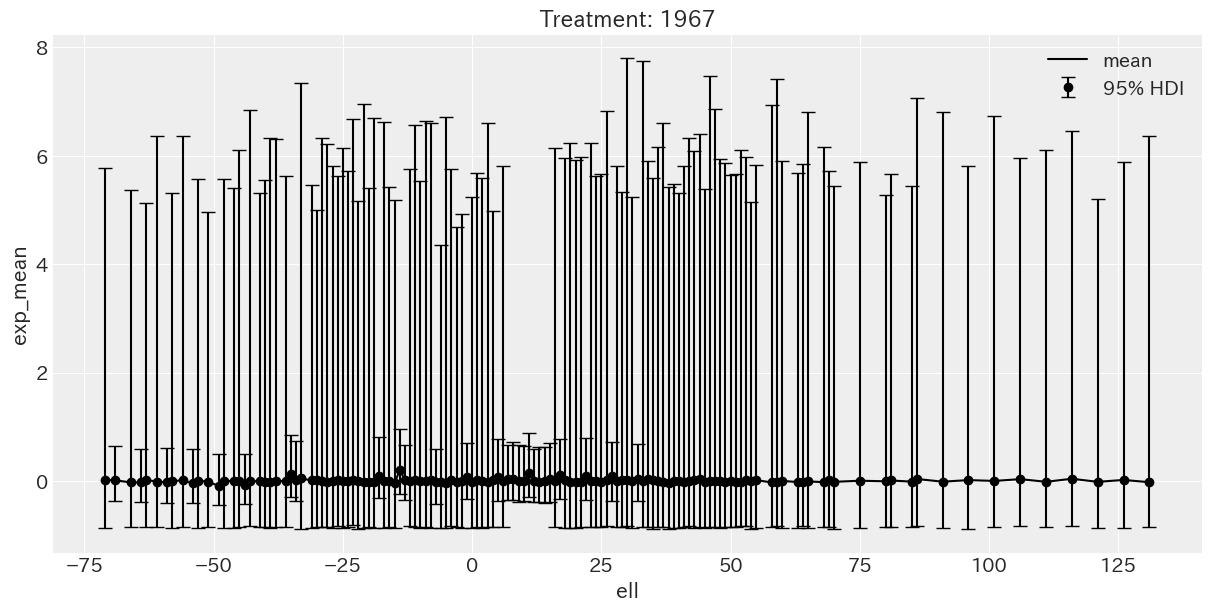

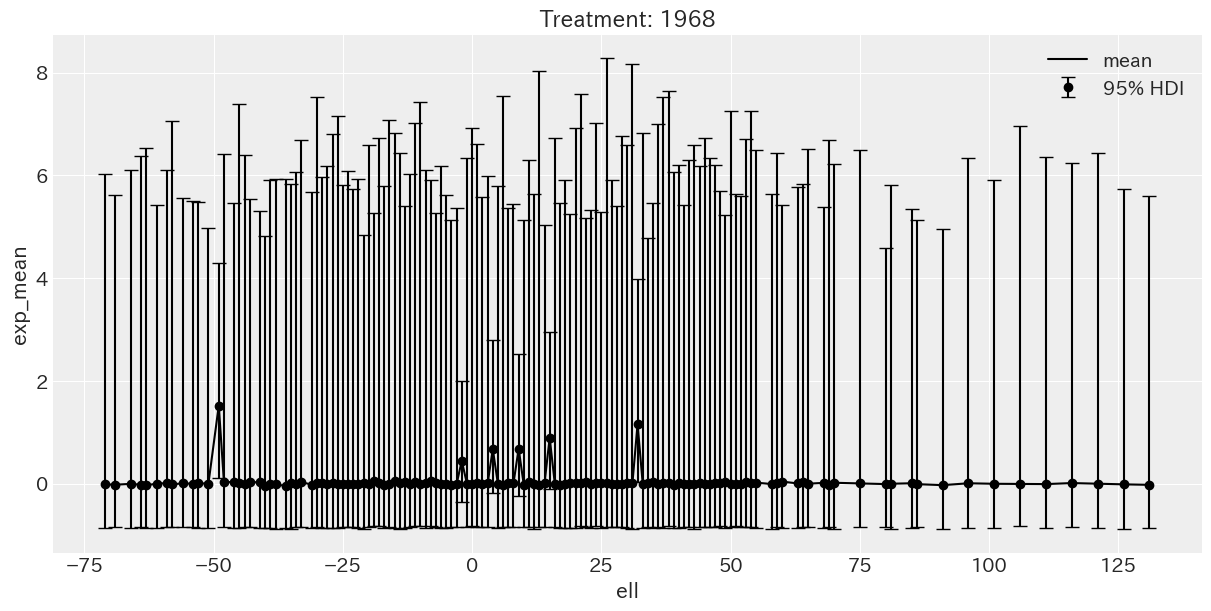

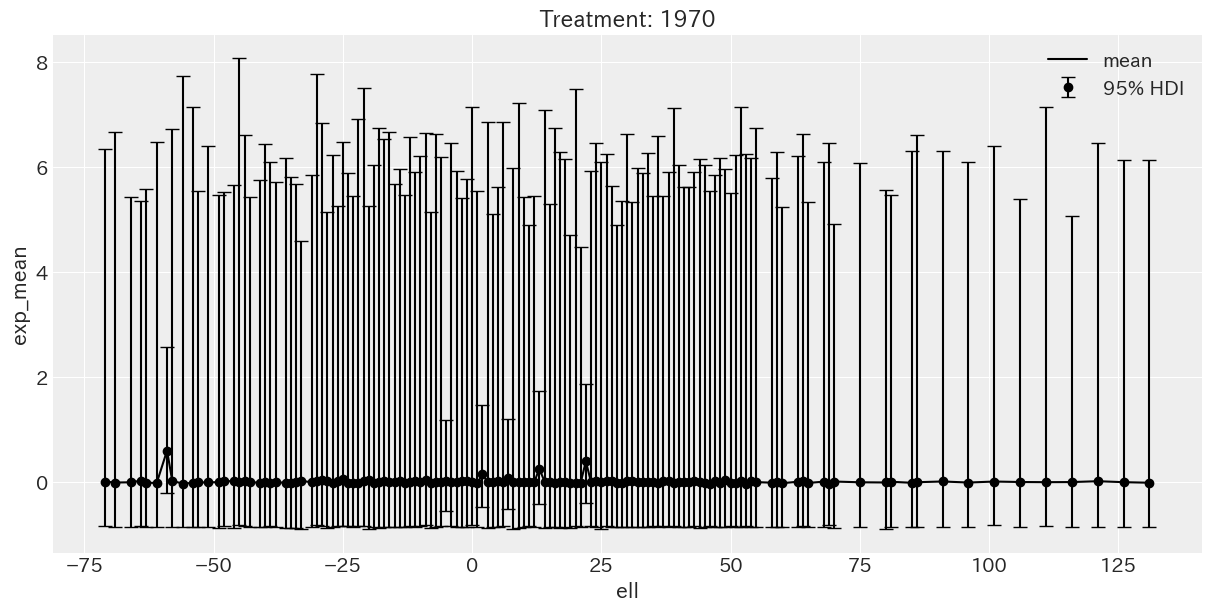

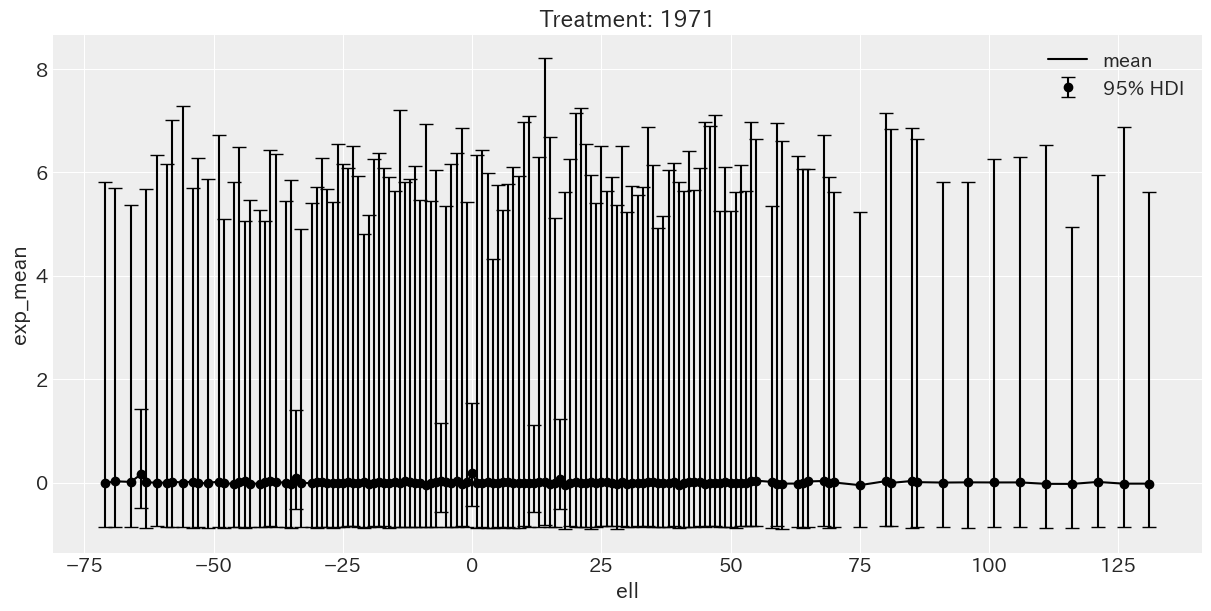

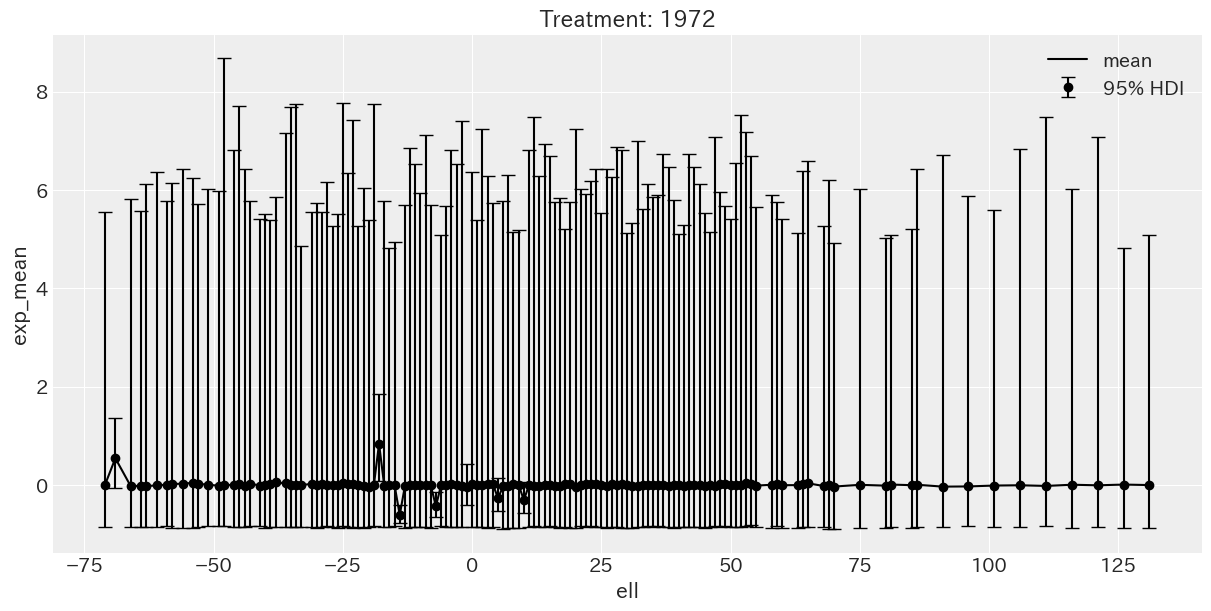

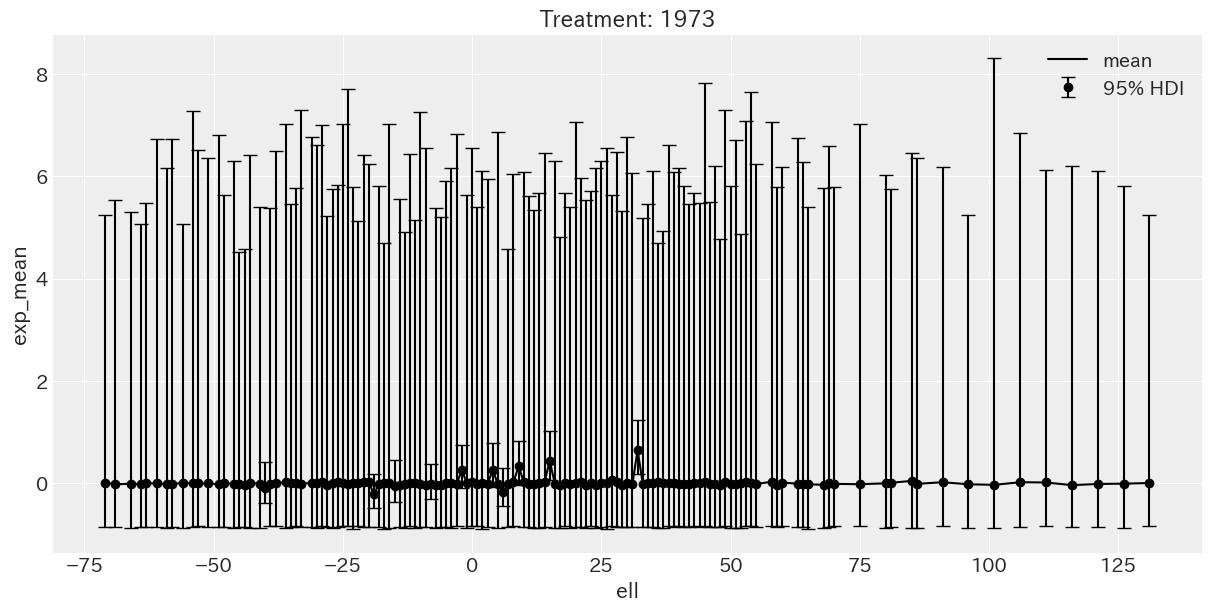

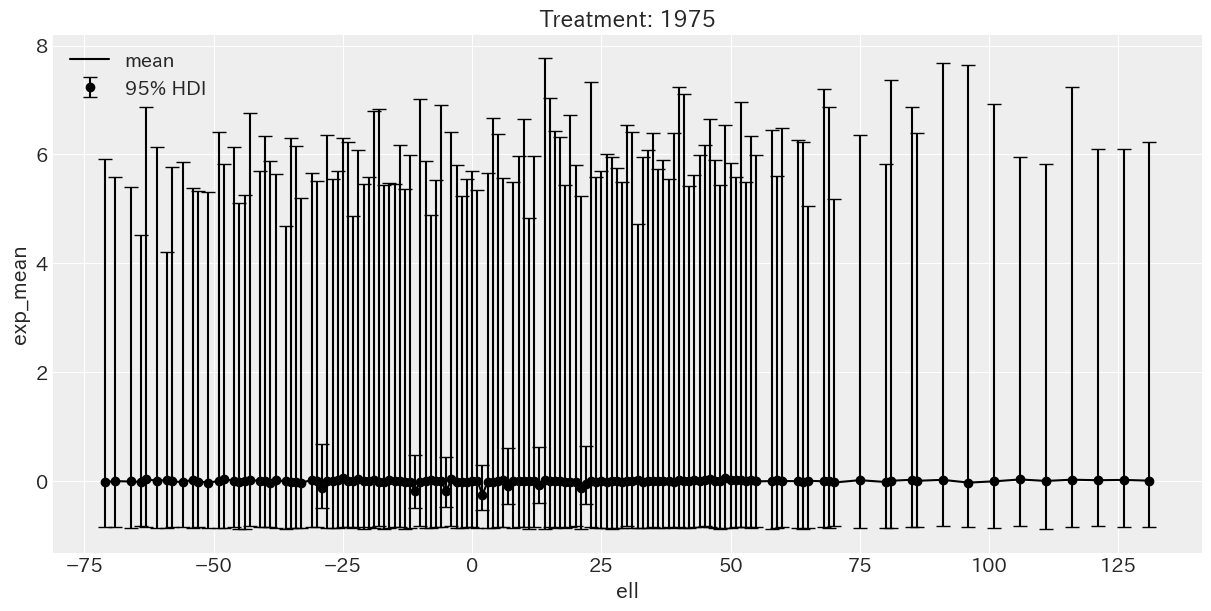

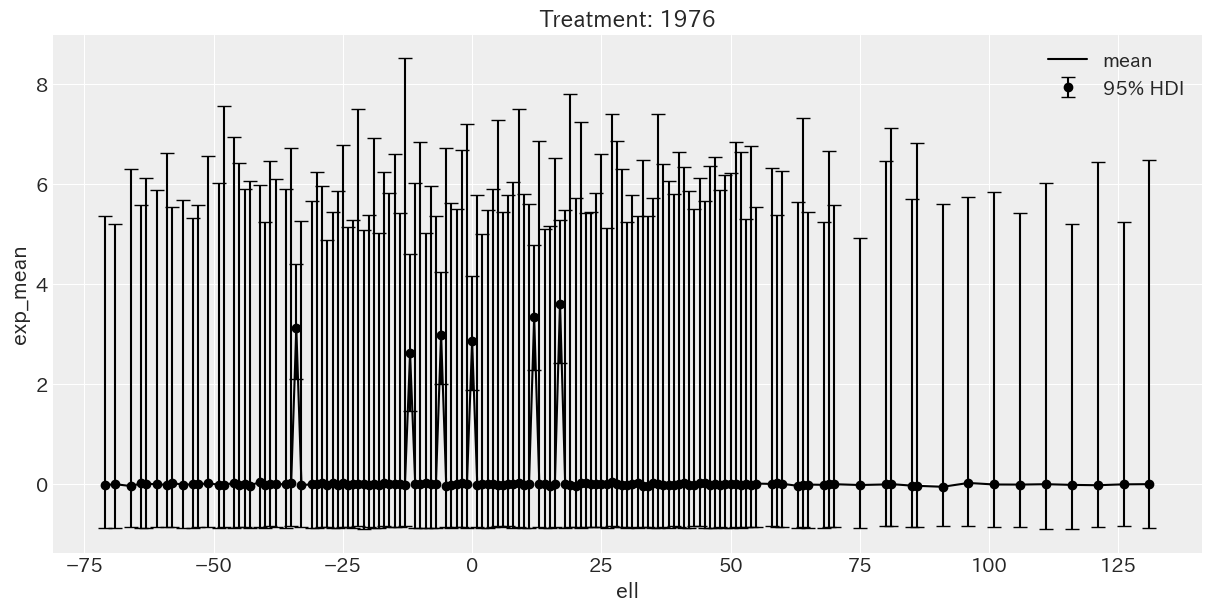

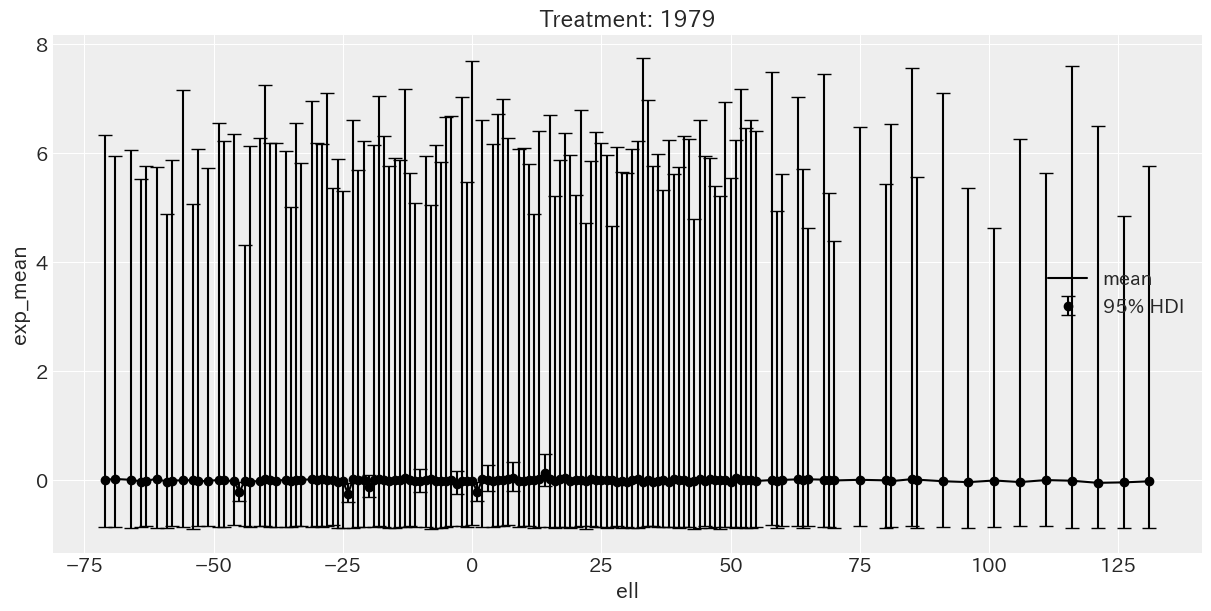

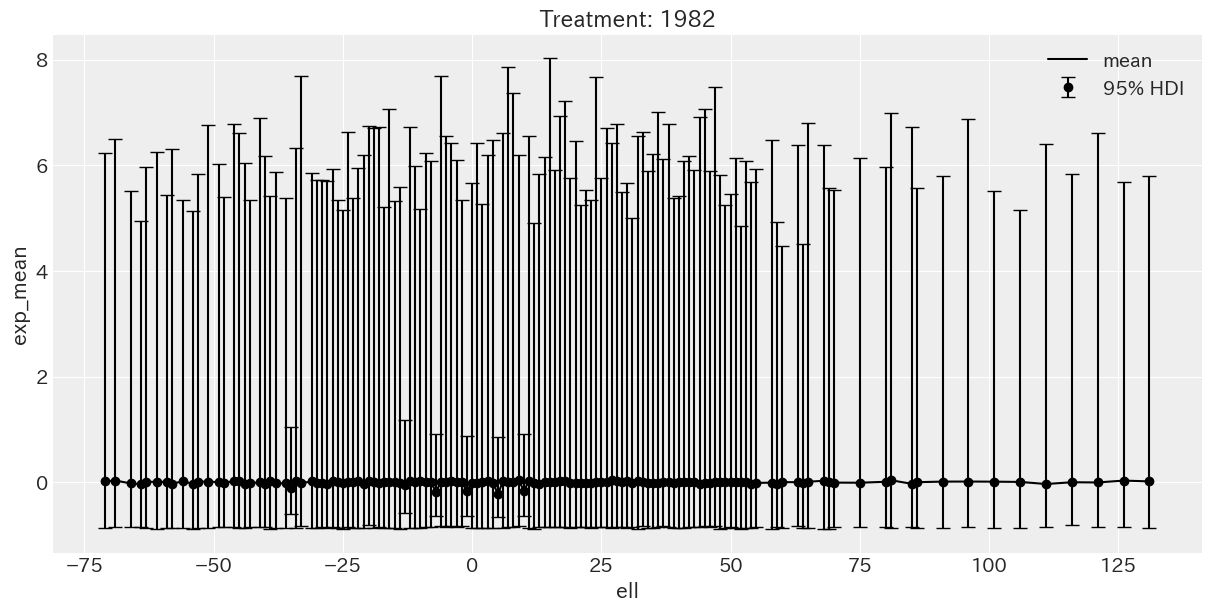

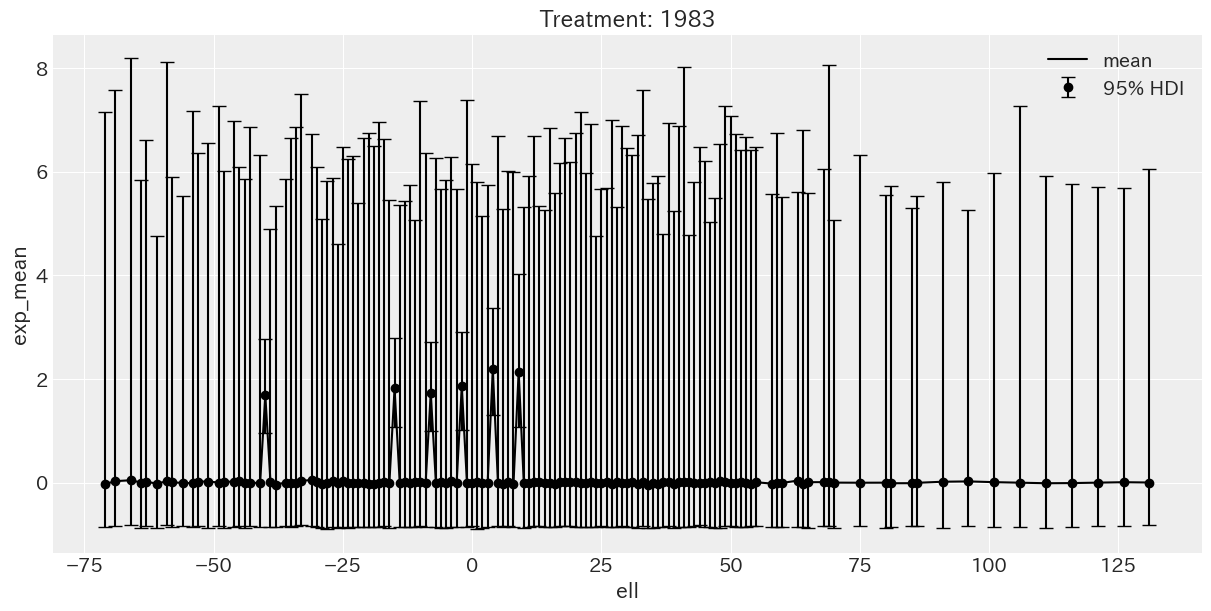

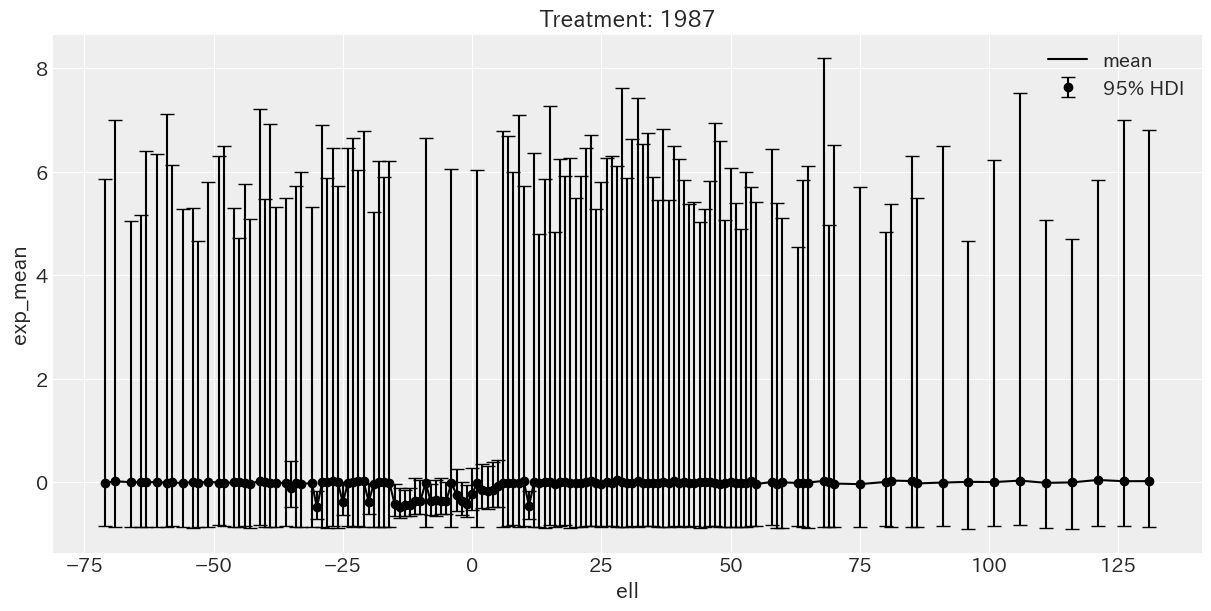

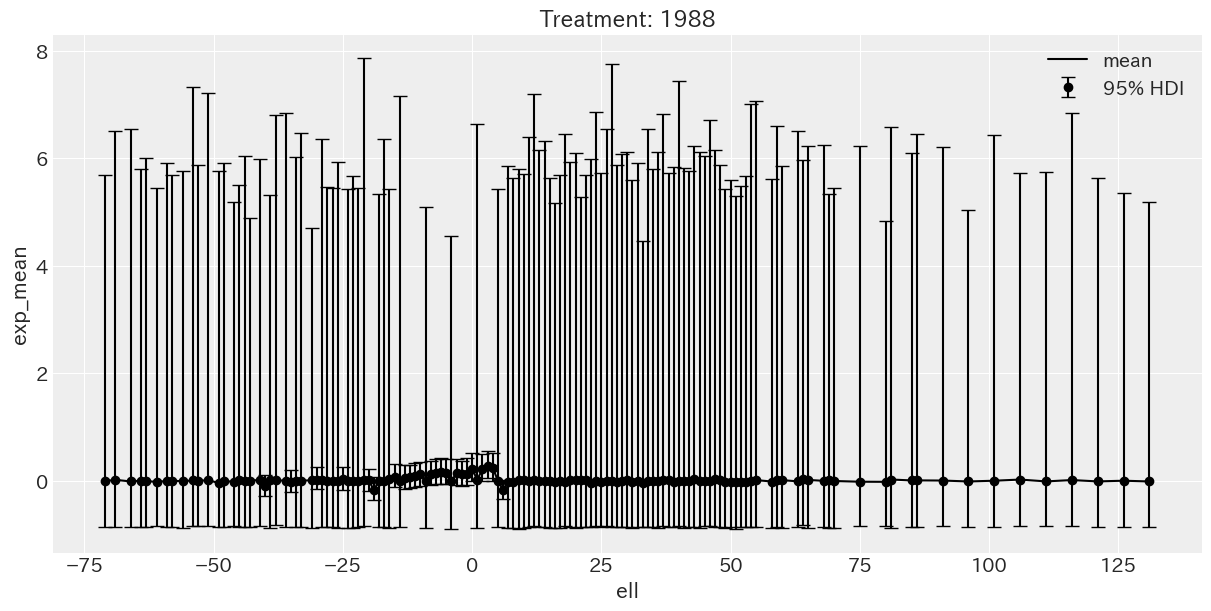

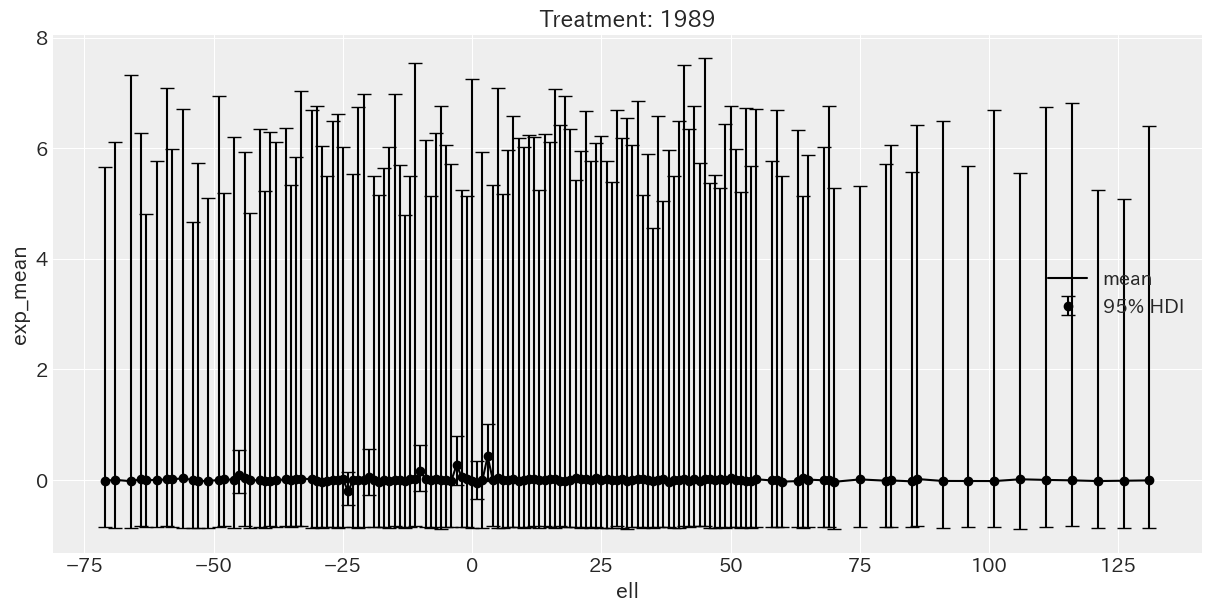

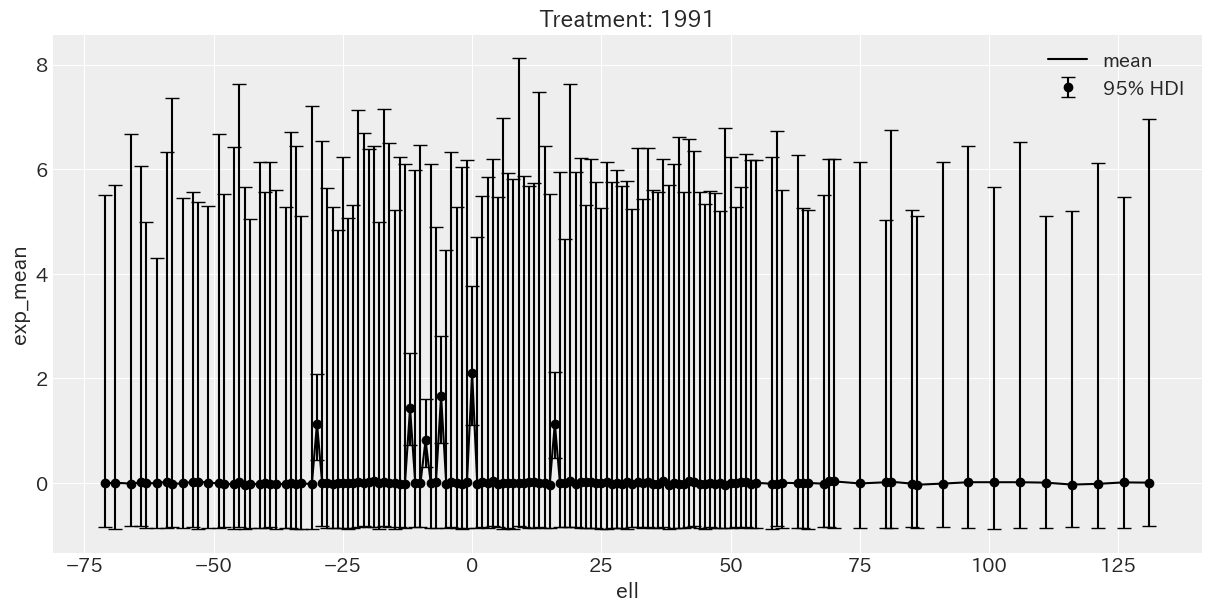

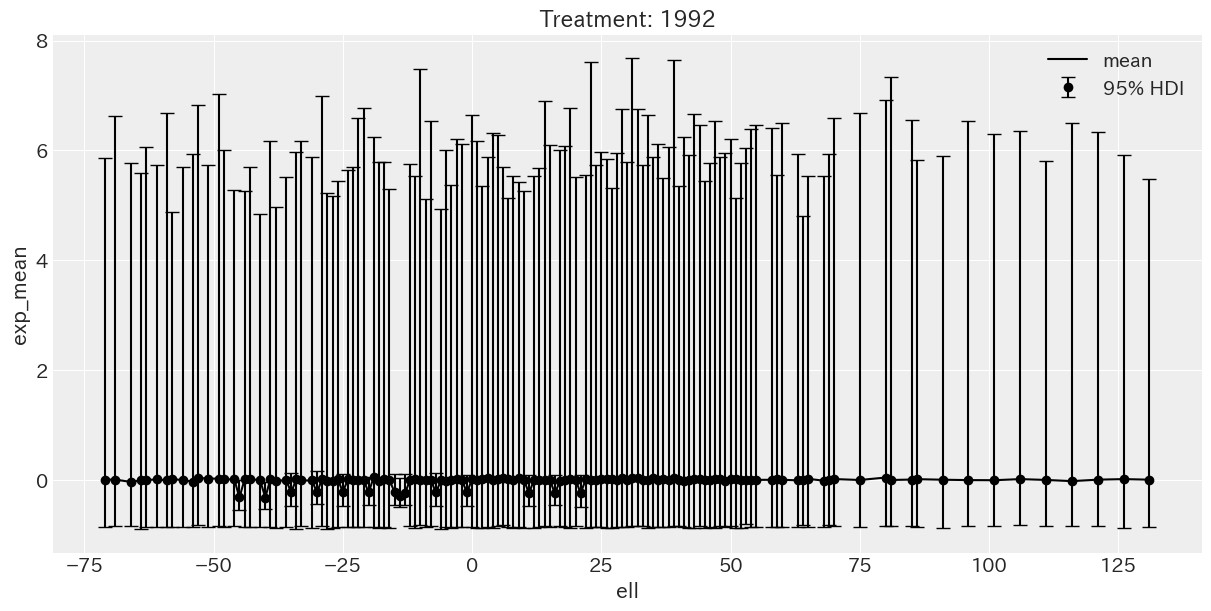

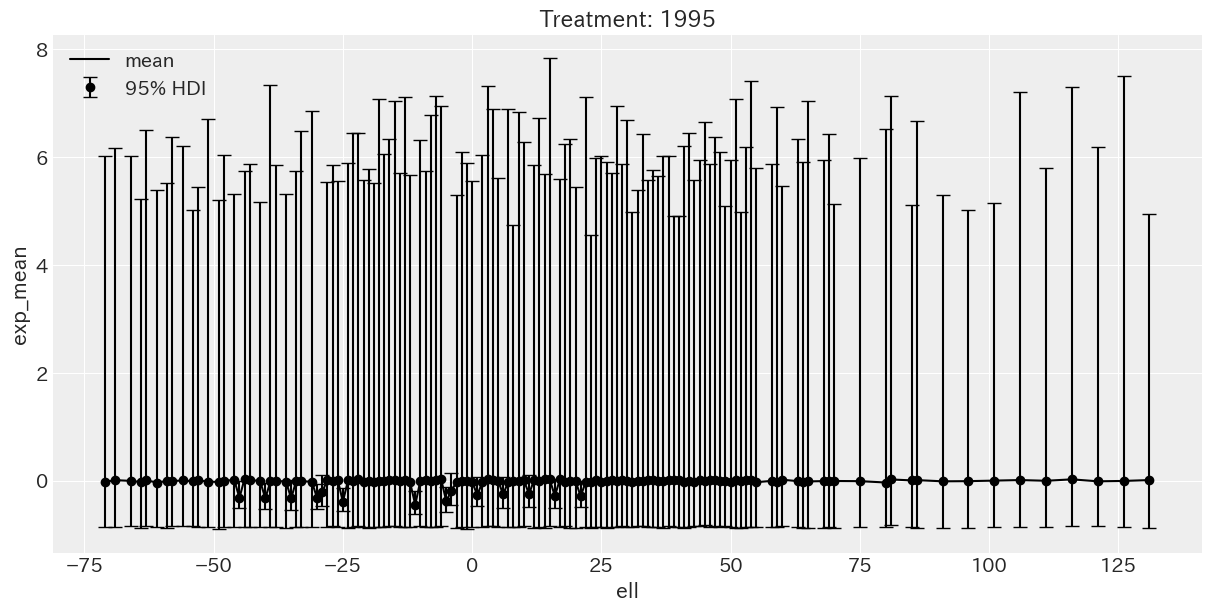

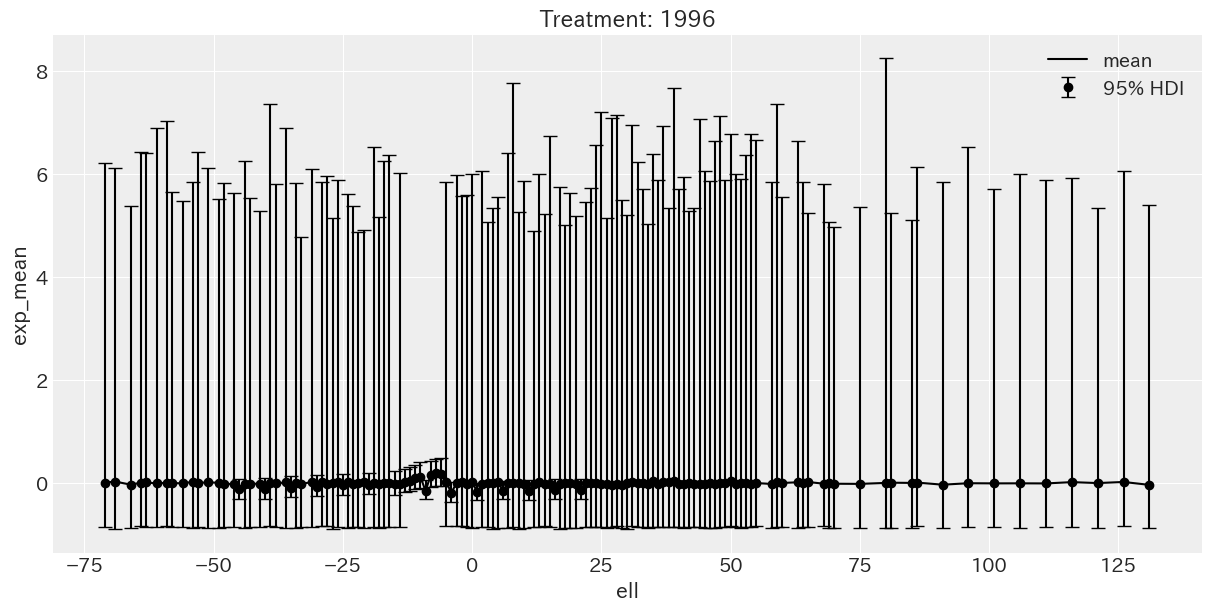

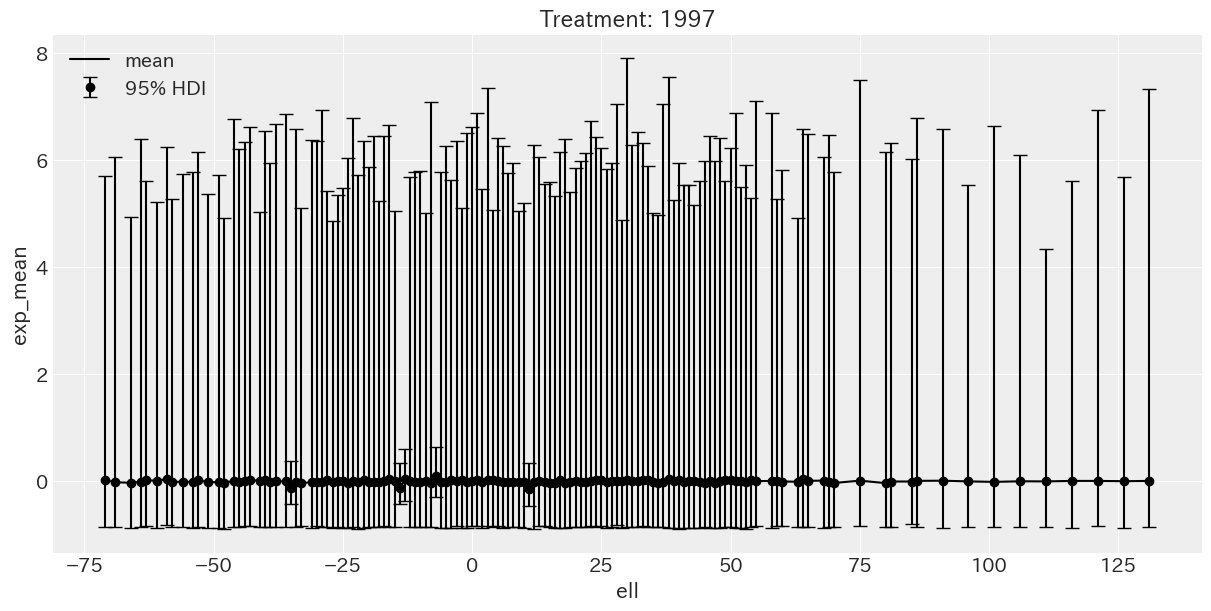

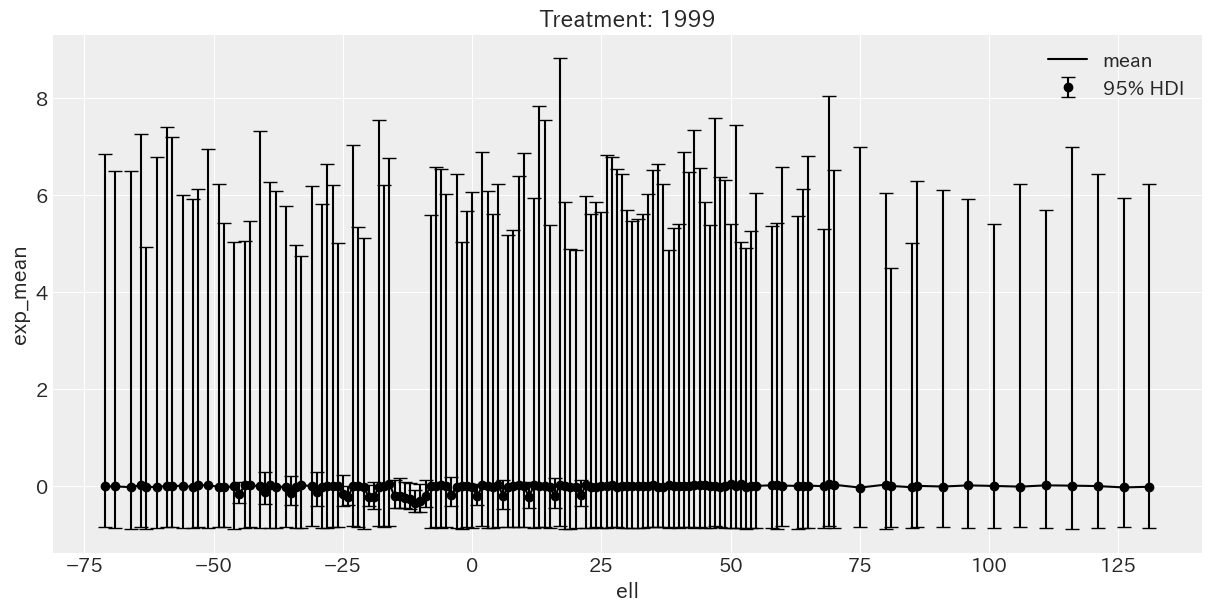

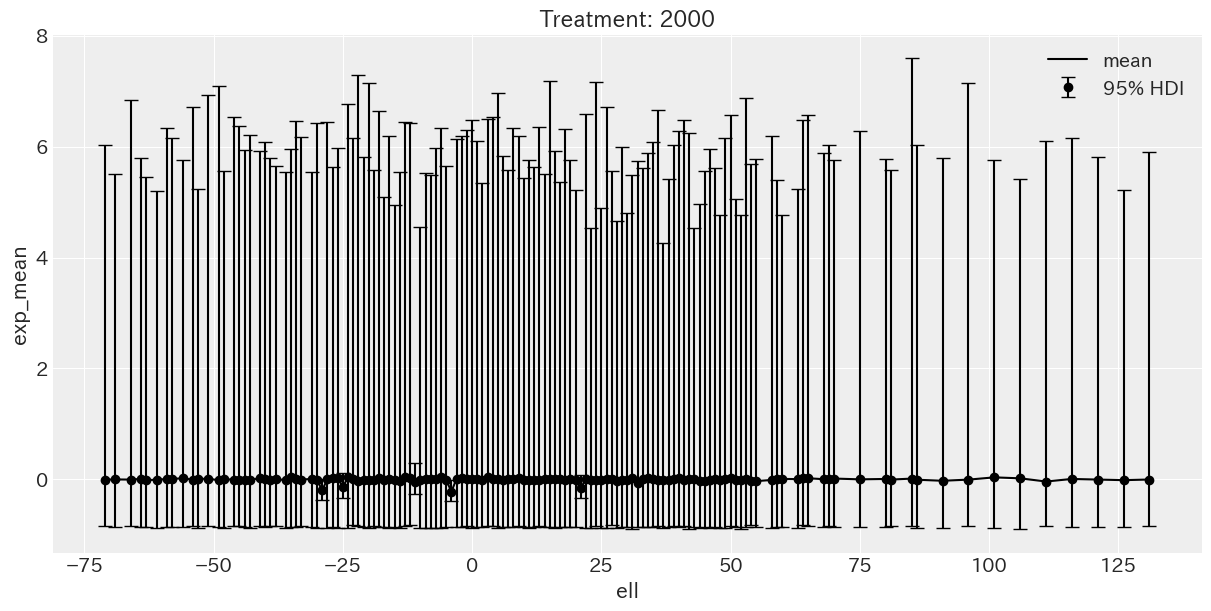

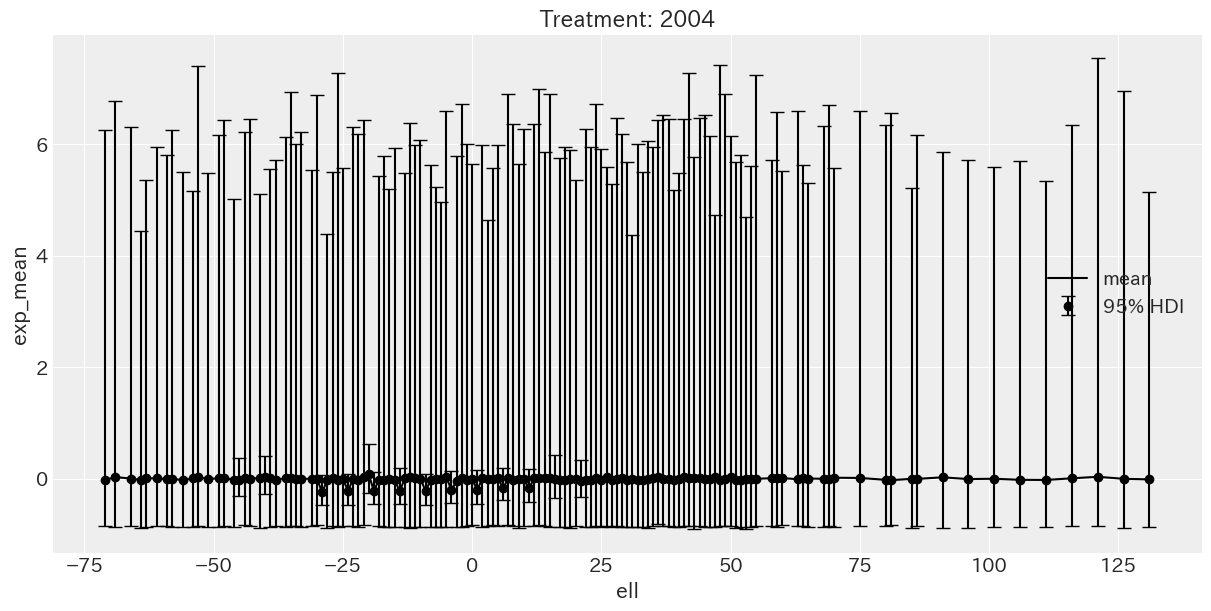

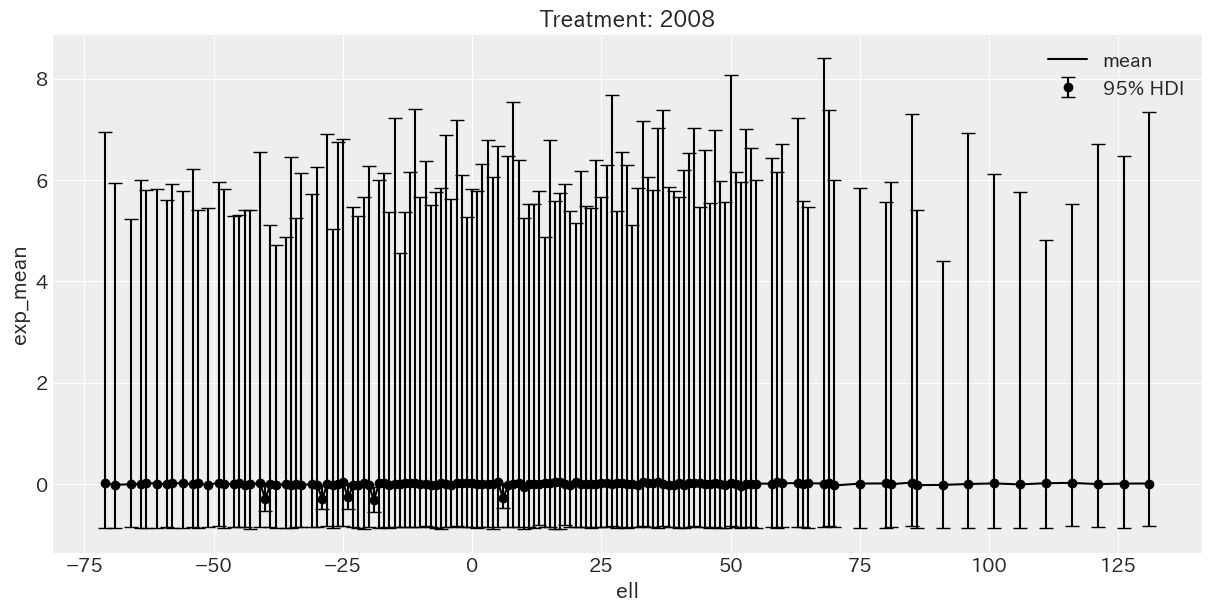

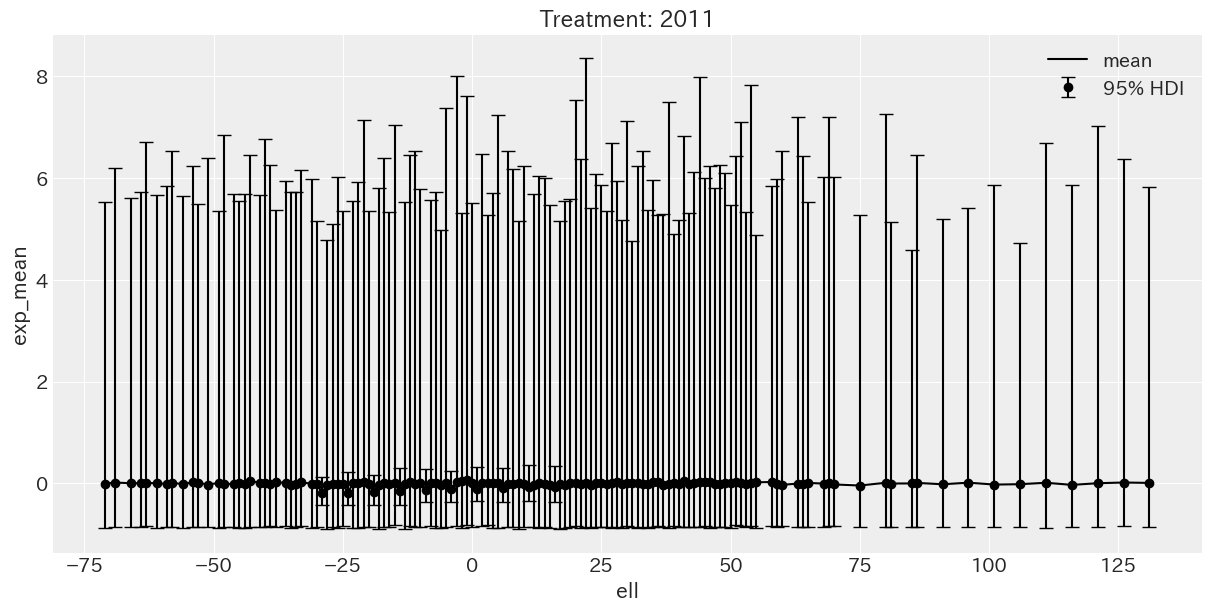

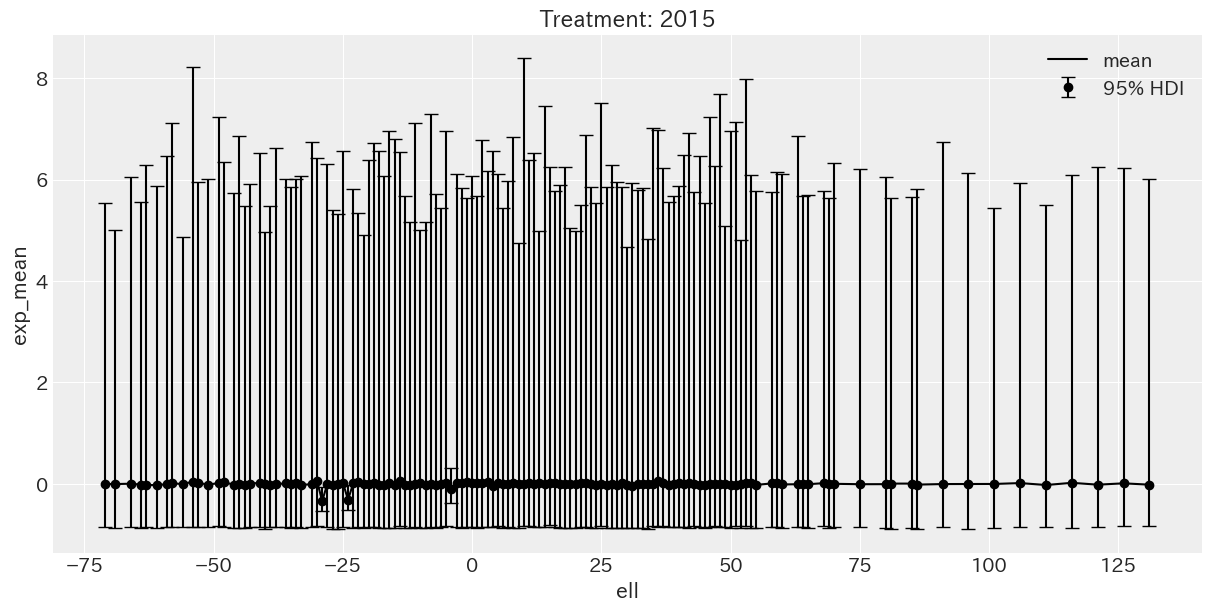

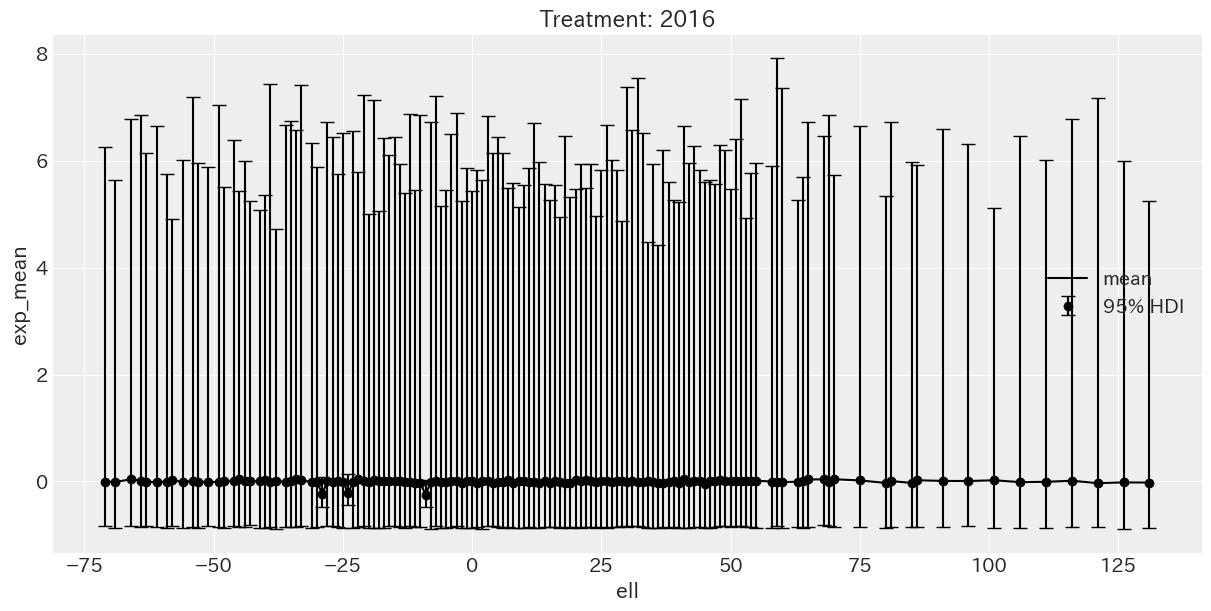

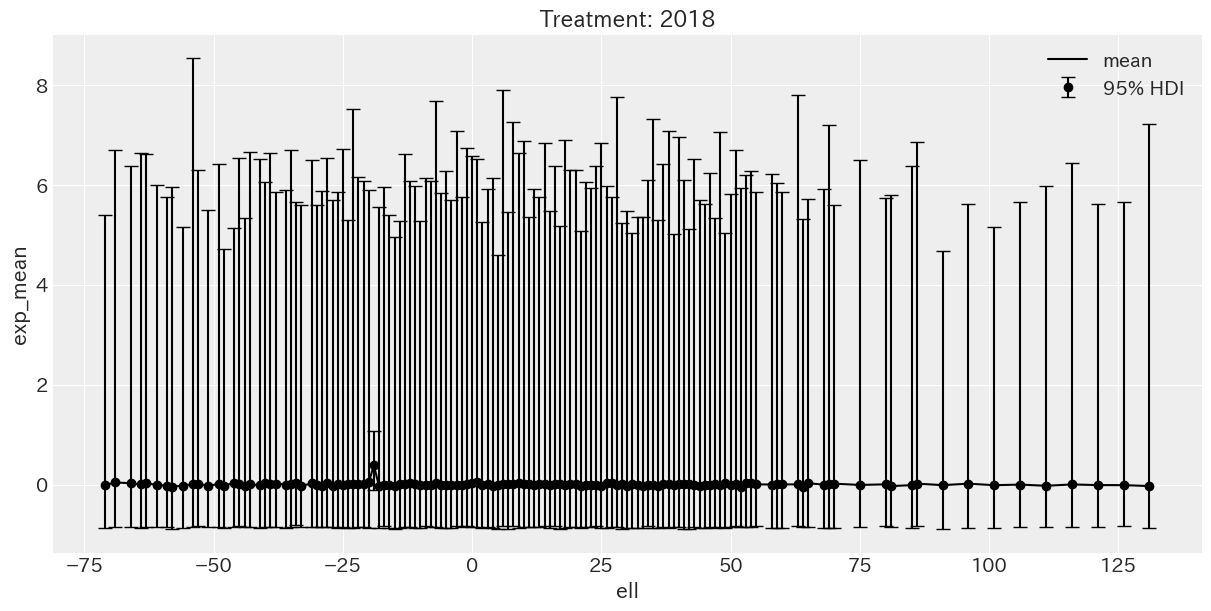

In [21]:
for treat in treat_list:
    plot_delta_treat_exp(gamma_df, treat)